In [2]:
import os
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
sys.path.append('..')

In [4]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms.functional import gaussian_blur
torch.jit.script = lambda x: x

import re 
import h5py
from glob import glob
from functools import partial
from tqdm import tqdm

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy.spatial.distance import pdist, cdist
from scipy import stats

from hpst.trainers.singleton_point_set_trainer import PointSetTrainer
from hpst.dataset.heterogenous_sparse_sim_dataset import HeterogenousSparseDataset
from hpst.utils.options import Options


# from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# from pytorch_grad_cam.utils.image import show_cam_on_image

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import cmasher as cmr
import seaborn as sb

KeyboardInterrupt: 

In [ ]:
from pathlib import Path

In [ ]:
BASE_DIR = Path("/home/roblesee/dune/hpst/data/sim_data/train")

In [ ]:
CACHE_DIR = (BASE_DIR / ".." / f"{BASE_DIR.name}_cache").resolve()

In [ ]:
CACHE_DIR

In [ ]:
CUDA = True
CUDA_DEVICE = 0
USE_TEX = False
TESTING_FILE = None

# TESTING_SOURCE = "interpretation"
# GRADIENT = False

# TESTING_SOURCE = "production"
# GRADIENT = False

TESTING_SOURCE= "testing"
GRADIENT = False

NETWORK = PointSetTrainer

In [ ]:
TESTING_FILE = "/home/roblesee/dune/hpst/data/sim_data/train"
BASE_DIRECTORY =  "../results/hpst/lightning_logs/version_203"
CHECKPOINT_PATH = "../results/hpst/lightning_logs/version_203/checkpoints/last.ckpt"

# Load checkpoint and add the test file location
options = Options.load(f"{BASE_DIRECTORY}/options.json")
"""
if TESTING_FILE:
    options.testing_file = TESTING_FILE
else:
    options.testing_file = options.training_file.replace("training", TESTING_SOURCE)
options.num_dataloader_workers = 0
"""
options.training_file = TESTING_FILE

if CHECKPOINT_PATH is None:
    checkpoints = glob(f"{BASE_DIRECTORY}/checkpoints/epoch*.ckpt")
    last_checkpoint = np.argmax([int(re.search("step=(.*).ckpt", s)[1]) for s in checkpoints])
    checkpoint_path = checkpoints[last_checkpoint]
else:
    checkpoint_path = CHECKPOINT_PATH
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint["state_dict"]
print(f"Loading from: {checkpoint_path}")

network = NETWORK(options)
network.load_state_dict(state_dict)

network = network.eval()

if not GRADIENT:
    for parameter in network.parameters():
        parameter.requires_grad_(False)

if CUDA:
    network = network.cuda(CUDA_DEVICE)

In [10]:
import matplotlib

In [11]:
DATASET = network.validation_dataset

In [12]:
DATASET.hits_index.shape

torch.Size([48785812])

In [13]:
DATASET.return_index = True

In [14]:
dataloader_options = network.dataloader_options
dataloader_options["pin_memory"] = False
dataloader_options["num_workers"] = 0
dataloader_options["batch_size"] = 128
dataloader_options["drop_last"] = False

test_dataloader = network.dataloader(DATASET, **dataloader_options)

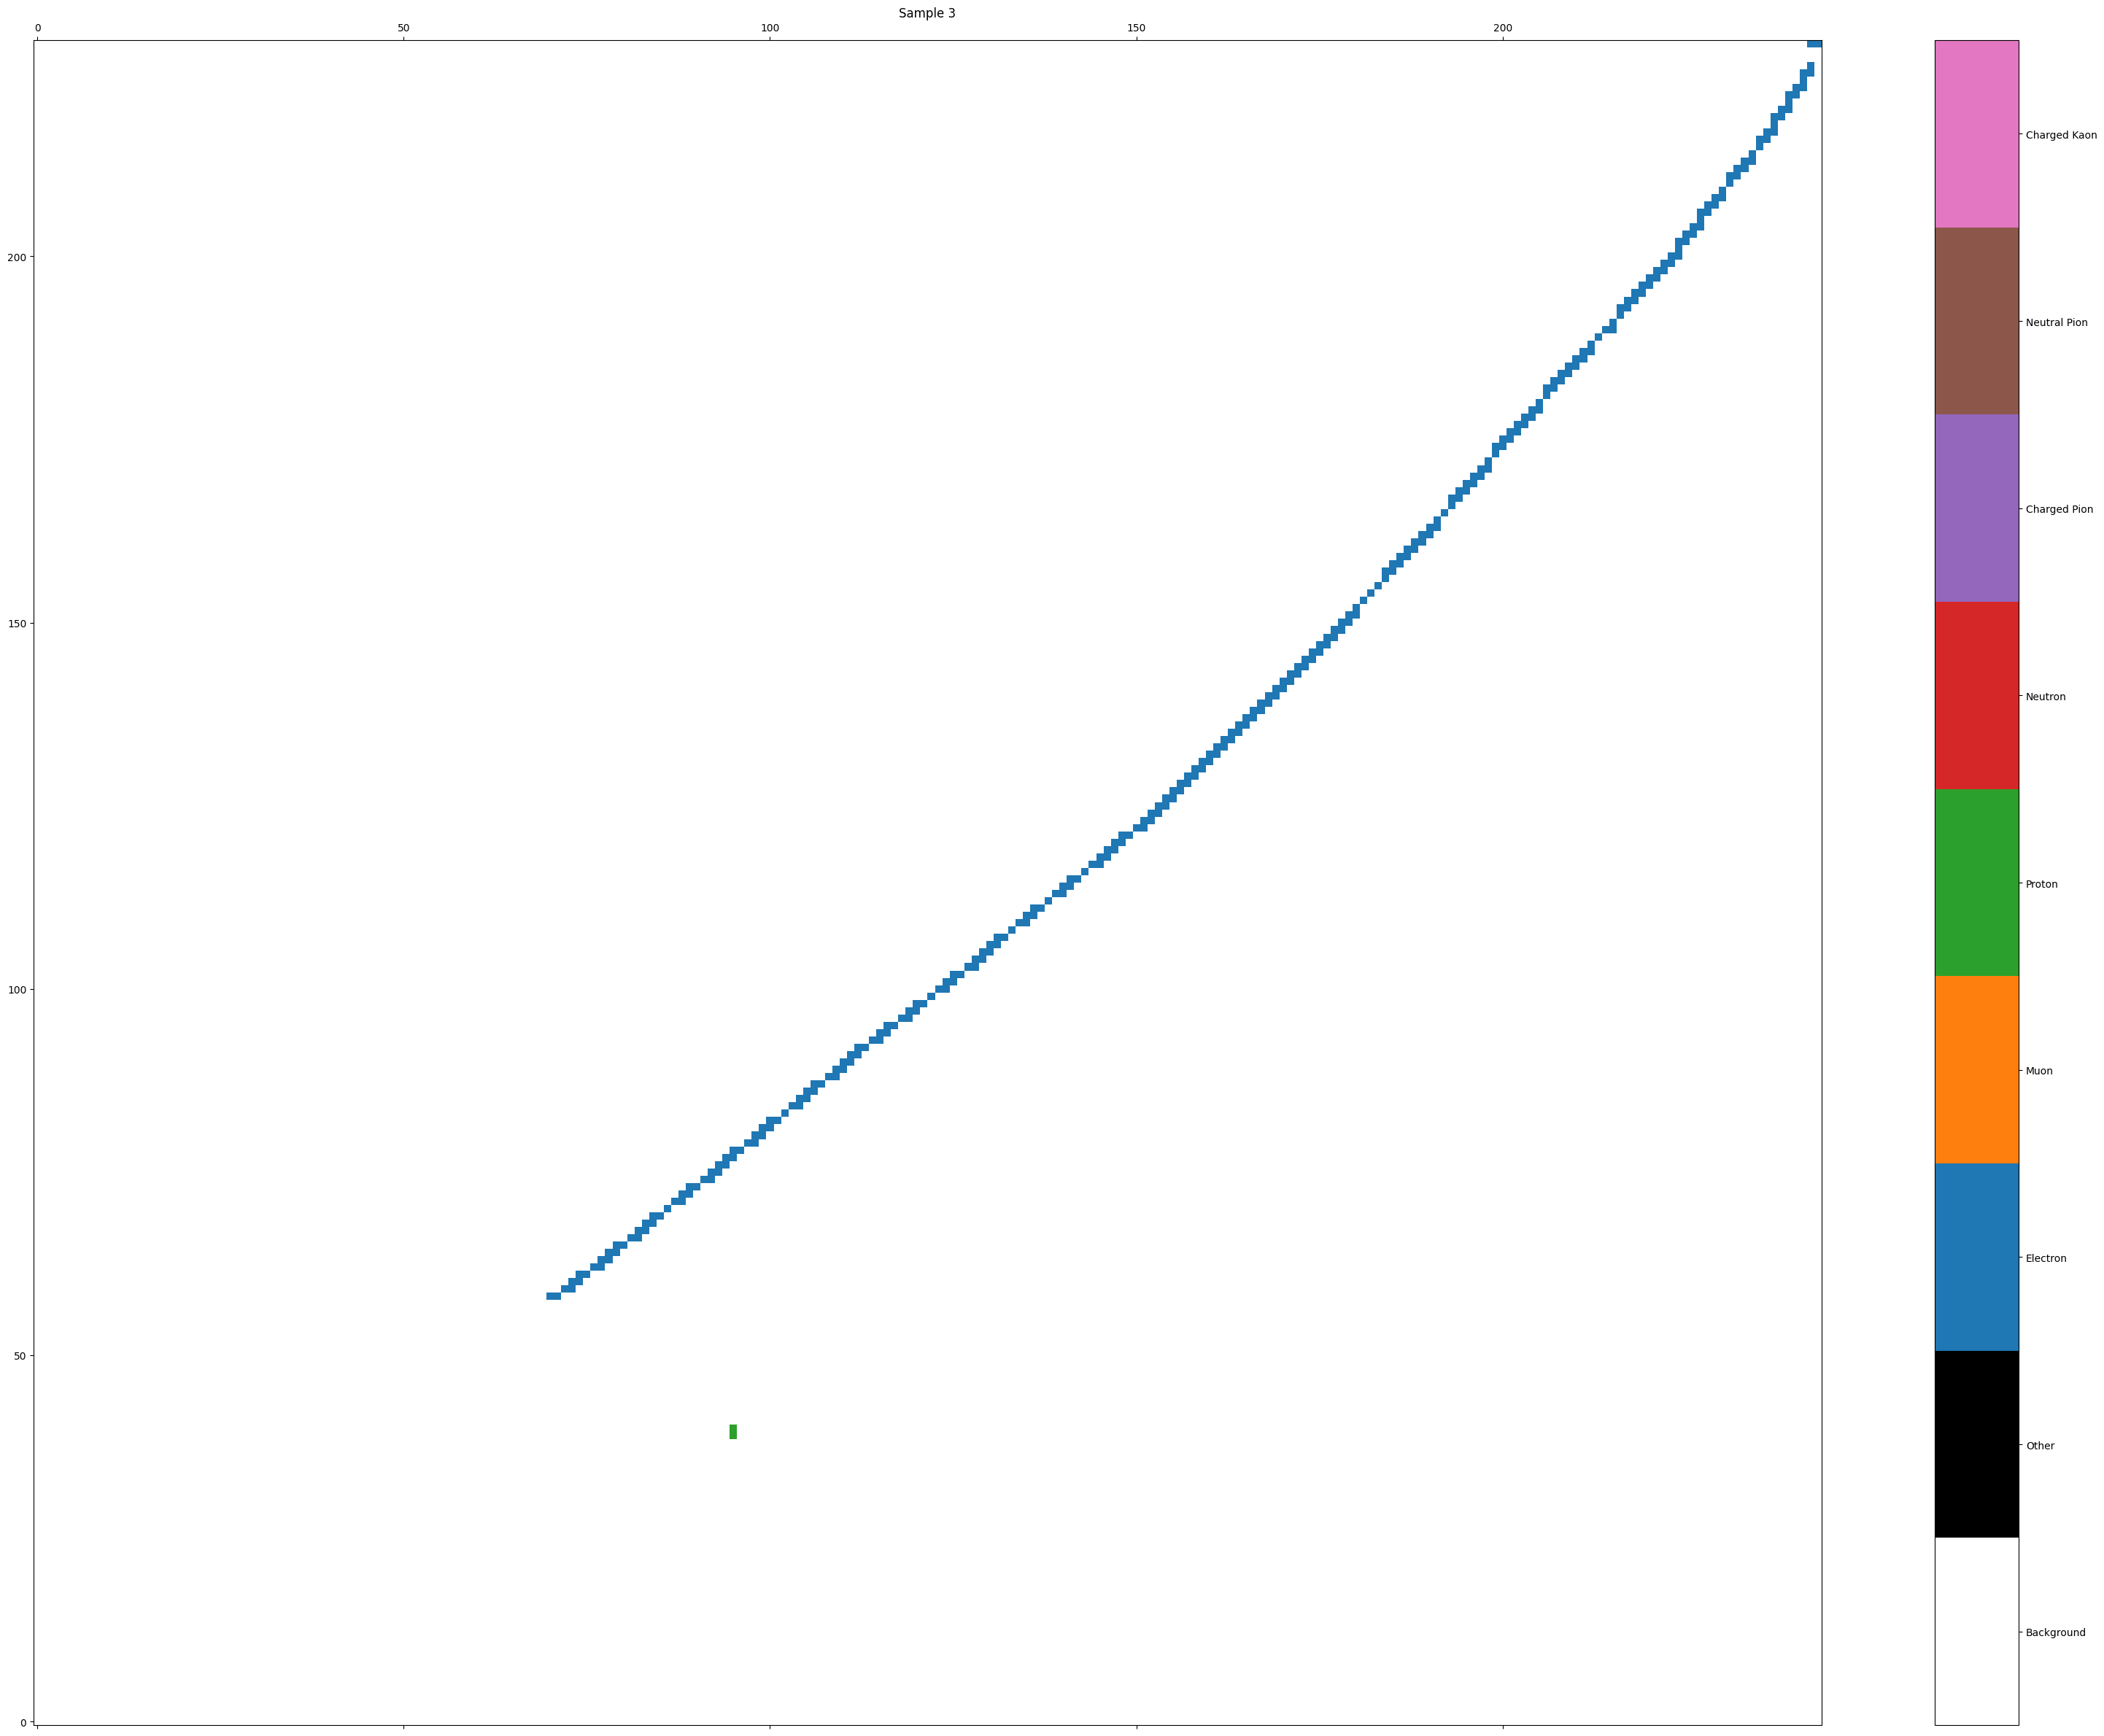

In [15]:
skip = 0*30
i = 2
targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)

(did, ( features, 
        coordinates, 
        targets,
        object_targets,)) = DATASET[i + 1 + skip]

coordinates = (coordinates - coordinates.amin(dim=0, keepdim=True)).to(torch.int64)
mat_size = coordinates.amax(dim=0) + 1
mat2d = np.zeros((mat_size[2], mat_size[0]))

mat2d[coordinates[:,2], coordinates[:,0]] = targets

scale = 10
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*4,scale*3))
ax = axs
mat2d[mat2d == 0] = np.nan
ax.set_title(f"Sample {did}")
im = ax.matshow(mat2d.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
ax.invert_yaxis()
cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
plt.show()

In [16]:
total_coords1 = []
total_coords2 = []

total_predictions1 = []
total_predictions2 = []

total_object_predictions1 = []
total_object_predictions2 = []


total_targets1 = []
total_targets2 = []

total_object_targets1 = []
total_object_targets2 = []

total_raws1 = []
total_raws2 = []

total_batch_idx1 = []
total_batch_idx2 = []

current_batch1 = 0
current_batch2 = 0

num_objects = 10

total_ids = []
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1 = network.forward(
        features1, coordinates1, batches1
    )
    
    total_ids.append(ids)
    
    mask1 = ((targets1 != -1))#(object_targets1 < num_objects))
    
    total_coords1.append(coordinates1[mask1].cpu())
    
    total_predictions1.append(predictions1[mask1].argmax(-1).cpu())
    
    total_object_predictions1.append(object_predictions1[mask1].argmax(-1).cpu())
    
    total_targets1.append(targets1[mask1].cpu())
    
    total_object_targets1.append(object_targets1[mask1].cpu())
    
    total_raws1.append(predictions1[mask1].cpu())
    
    total_batch_idx1.append(batches1[mask1].cpu() + current_batch1 + 1)
    current_batch1 += batches1.max().item() + 1
    
total_predictions1 = torch.cat(total_predictions1)
total_targets1 = torch.cat(total_targets1)
total_raws1 = torch.cat(total_raws1)
total_batch_idx1 = torch.cat(total_batch_idx1)
total_coords1 = torch.cat(total_coords1)
total_ids = torch.cat(total_ids)
total_object_predictions1 = torch.cat(total_object_predictions1)
total_object_targets1 = torch.cat(total_object_targets1)

100%|████████████████████████████████████████████████████████████████| 183/183 [01:03<00:00,  2.88it/s]


(array([5.9183e+04, 9.6774e+04, 1.8831e+04, 1.4143e+04, 1.2437e+04,
        7.9290e+03, 1.5150e+03, 1.2520e+03, 0.0000e+00, 2.1510e+03,
        1.3230e+03, 4.7200e+02, 1.0900e+02, 9.9000e+01, 1.5000e+01,
        1.6000e+01, 2.0000e+00]),
 array([ 0.        ,  0.88235294,  1.76470588,  2.64705882,  3.52941176,
         4.41176471,  5.29411765,  6.17647059,  7.05882353,  7.94117647,
         8.82352941,  9.70588235, 10.58823529, 11.47058824, 12.35294118,
        13.23529412, 14.11764706, 15.        ]),
 [<matplotlib.patches.Polygon at 0x7fbe1447c1c0>])

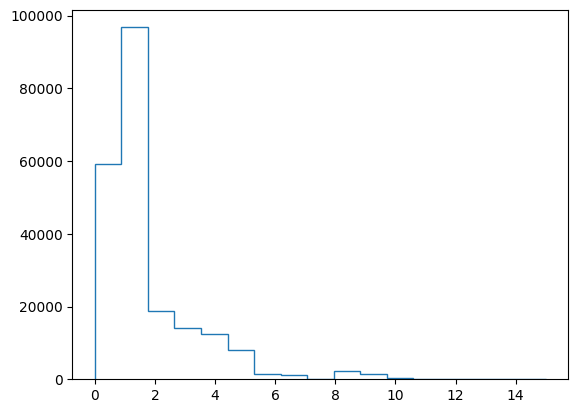

In [17]:
plt.hist(object_targets1.cpu(), bins=17, histtype="step")

In [18]:
(object_targets1 < 10).to(float).mean()

tensor(0.9967, device='cuda:0', dtype=torch.float64)

In [19]:
total_targets1.shape

torch.Size([48784594])

In [20]:
total_raws1.shape

torch.Size([48784594, 8])

In [21]:
total_probabilities1 = torch.softmax(total_raws1, dim=-1)

In [22]:
total_probabilities1.shape

torch.Size([48784594, 8])

In [23]:
unique = torch.cat([total_targets1[:].unique().long()]).unique()

In [24]:
unique

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [25]:
tp1 = total_probabilities1[:]/total_probabilities1[:].sum(axis=1, keepdim=True)

In [26]:
tp1.shape

torch.Size([48784594, 8])

In [27]:
tp = torch.cat([tp1], axis=0)
total_targets = torch.cat([total_targets1], axis=0)
total_predictions = torch.cat([total_predictions1], axis=0)
total_raws = torch.cat([total_raws1], axis=0)
total_object_predictions = torch.cat([total_object_predictions1], axis=0)
total_batch_idx = torch.cat([total_batch_idx1], axis=0)

In [28]:
tp.shape, total_targets.shape

(torch.Size([48784594, 8]), torch.Size([48784594]))

In [29]:
torch.unique(total_targets)

tensor([0, 1, 2, 3, 4, 5, 6, 7])

In [30]:
print(f"ROC AUC: {roc_auc_score(total_targets, tp/tp.sum(axis=-1,keepdims=True), multi_class='ovr', average='weighted'):.3f}")

ROC AUC: 0.983


In [31]:
CLASS_NAMES = {
    0: "other",
    1: "electron",
    2: "muon",
    3: "proton",
    4: "neutron",
    5: "charged pion",
    6: "neutral pion",
    7: "kaon"
}

Text(0.5, 1.0, 'Class distribution')

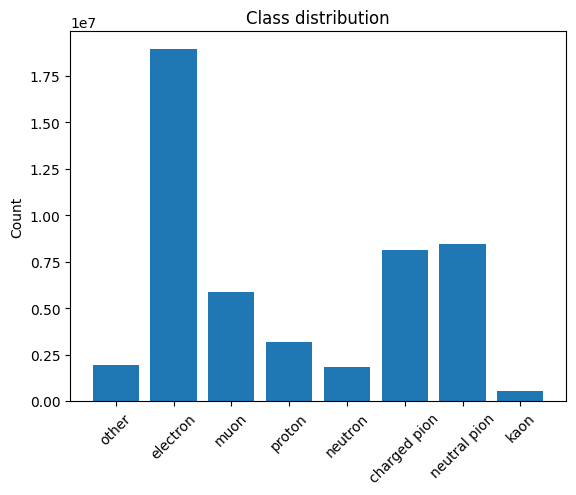

In [76]:
plt.bar(range(8), torch.bincount(total_targets).numpy())
plt.xticks(range(8), list(CLASS_NAMES.values()), rotation=45)
plt.ylabel("Count")
plt.title("Class distribution")

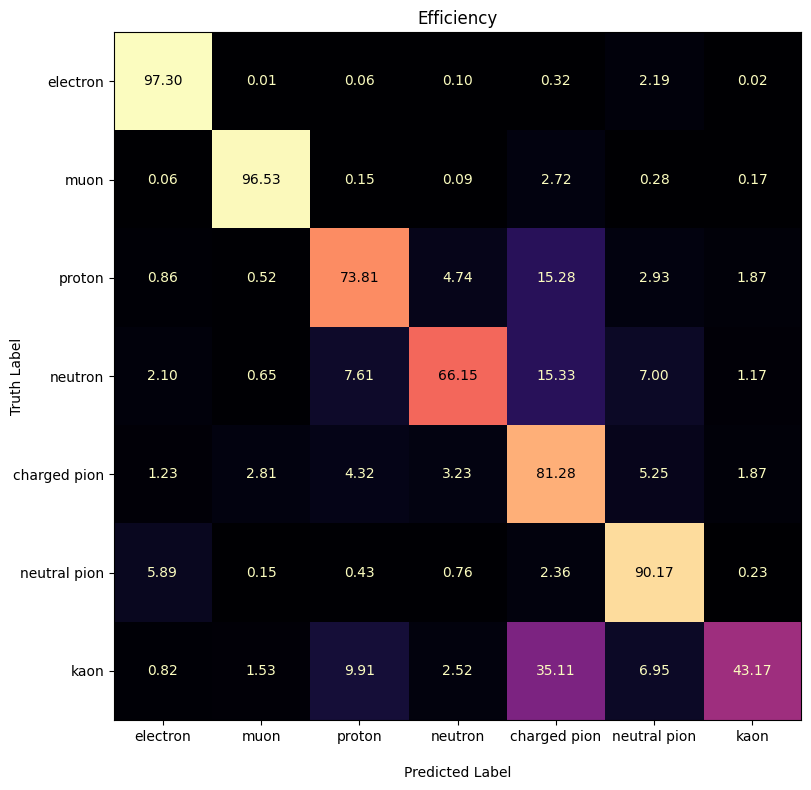

In [33]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    total_predictions.numpy(), 
    normalize='true',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Efficiency")
plt.tight_layout()

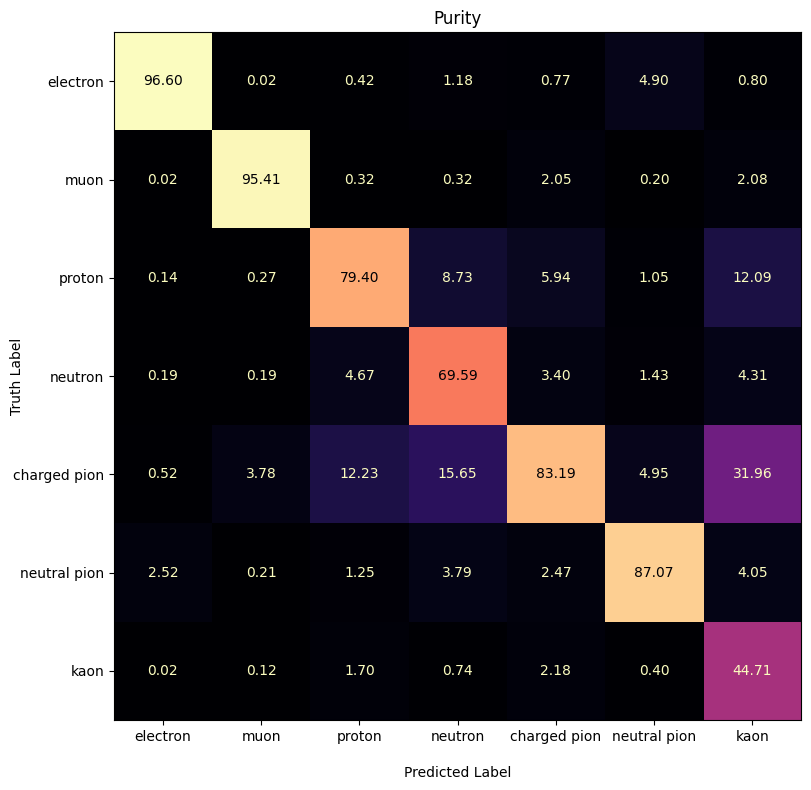

In [34]:
LABEL_ORDER = total_targets[:].unique()[1:].long()

confusion_matrix_pred = metrics.confusion_matrix(
    total_targets[:].numpy(), 
    total_predictions.numpy(), 
    normalize='pred',
    labels=LABEL_ORDER
)

fig, ax = plt.subplots(figsize=(10, 8))
display = metrics.ConfusionMatrixDisplay(
    confusion_matrix_pred * 100, 
    display_labels=[CLASS_NAMES[i.item()] for i in LABEL_ORDER]
)
display.plot(cmap='magma', ax=ax, values_format=".2f", colorbar=False)
ax.set_xlabel("Predicted Label", labelpad=16)
ax.set_ylabel("Truth Label", labelpad=-8)
plt.title("Purity")
plt.tight_layout()

In [35]:
from sklearn.metrics import roc_curve, auc

/home/roblesee/mambaforge/envs/torch25_cu11/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


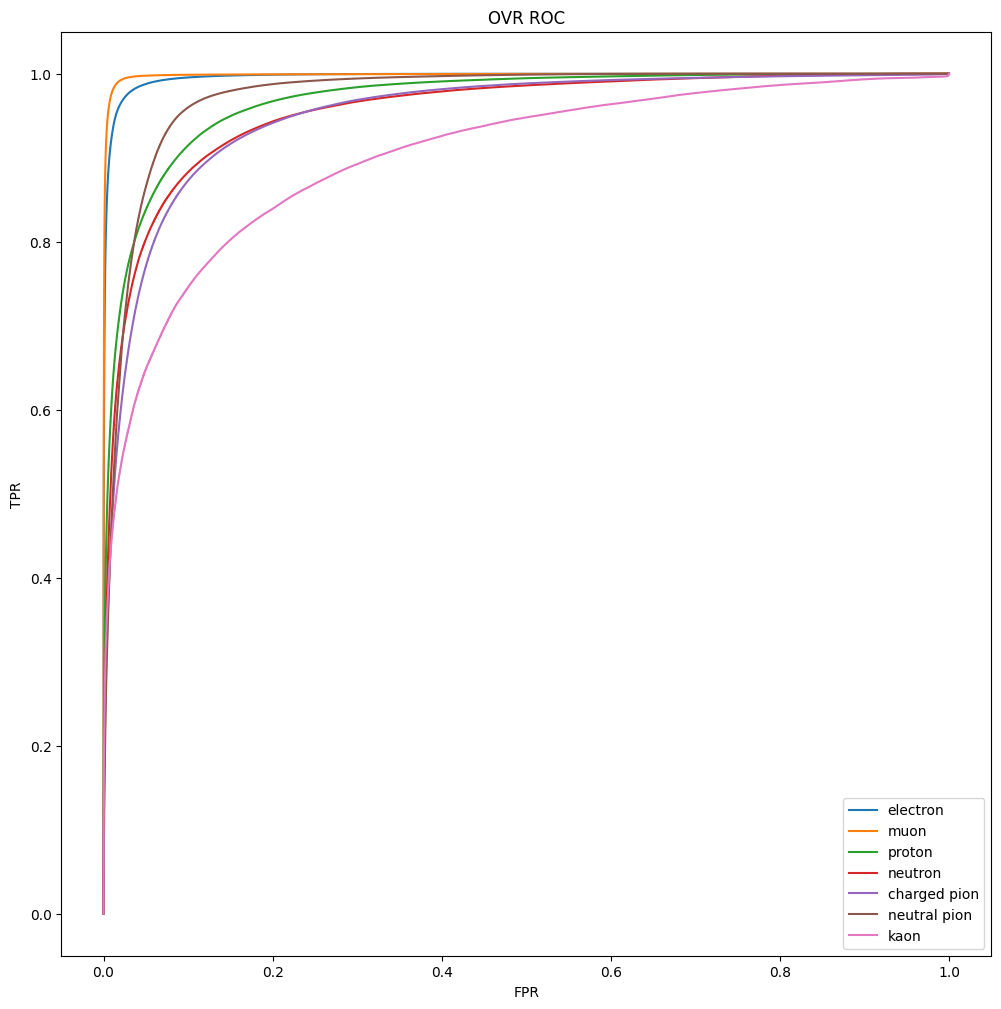

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))

for class_index in LABEL_ORDER:
    class_index = class_index.item()
    fpr, tpr, thresholds = roc_curve(
        total_targets.numpy()[:],
        total_raws.numpy()[:,class_index],
        pos_label=class_index
    )

    ax.plot(fpr, tpr, label=CLASS_NAMES[class_index])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")

ax.set_title("OVR ROC")
ax.legend()
plt.show()

In [37]:
total_batch_idx1[:1000]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

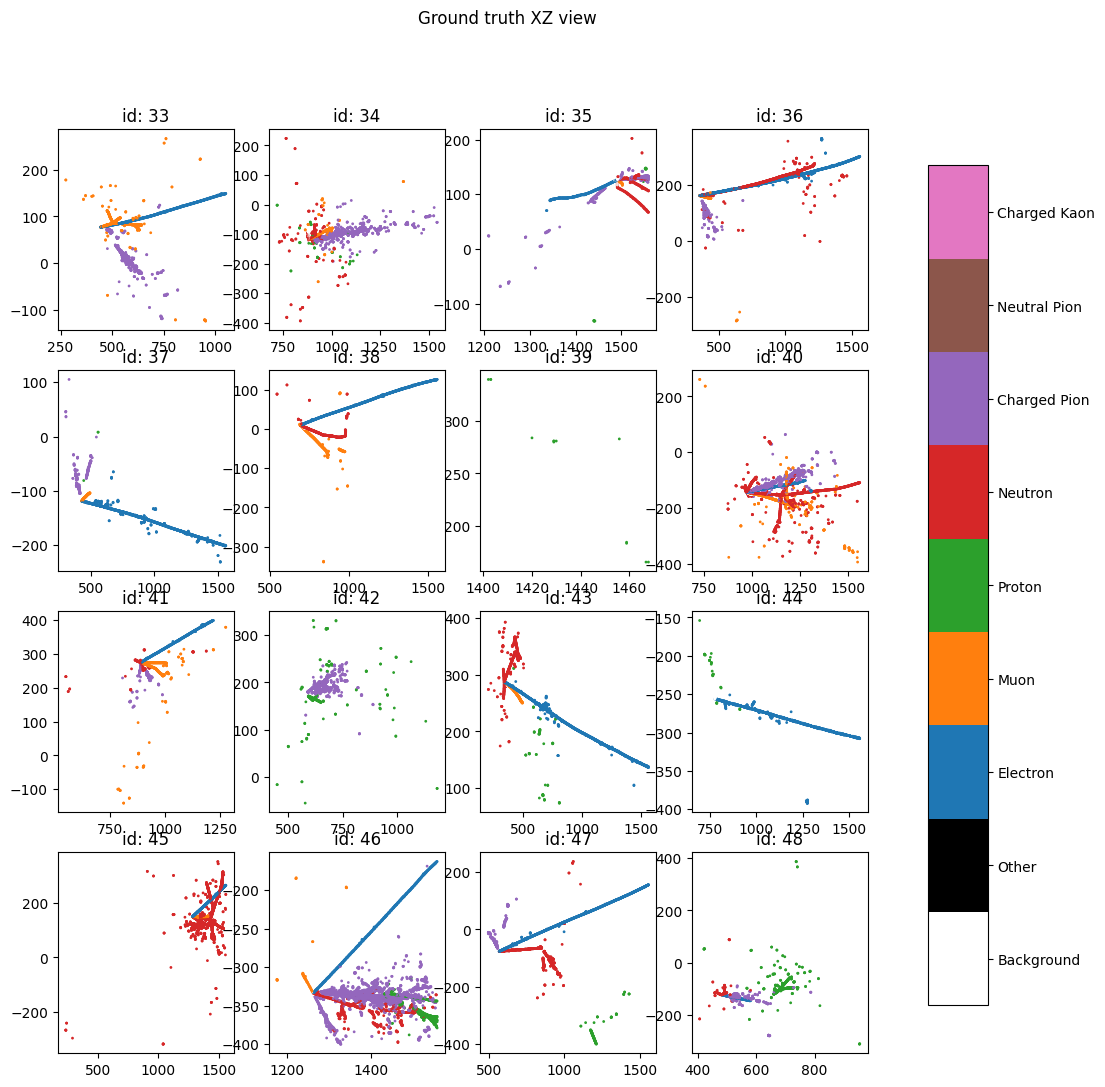

In [38]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_targets1[total_batch_idx1 == i+1+skip]
    ids = int(total_ids[i+1+skip].item())
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    im = ax.scatter(c[:,2], c[:,0], s=1, vmin=-0.5, vmax=8.5, c=t, cmap=targets_cmap)
    # ax.set_title("id: %d, unique: %s" % (ids, str(t[:,0].unique().tolist())))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,1,2,3,4,5,6,7, 8])
#cbar.set_ticks(list(CLASS_NAMES.keys()))
#cbar.set_ticklabels(list(CLASS_NAMES.values()))
cbar.set_ticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
plt.suptitle("Ground truth XZ view")
plt.show()

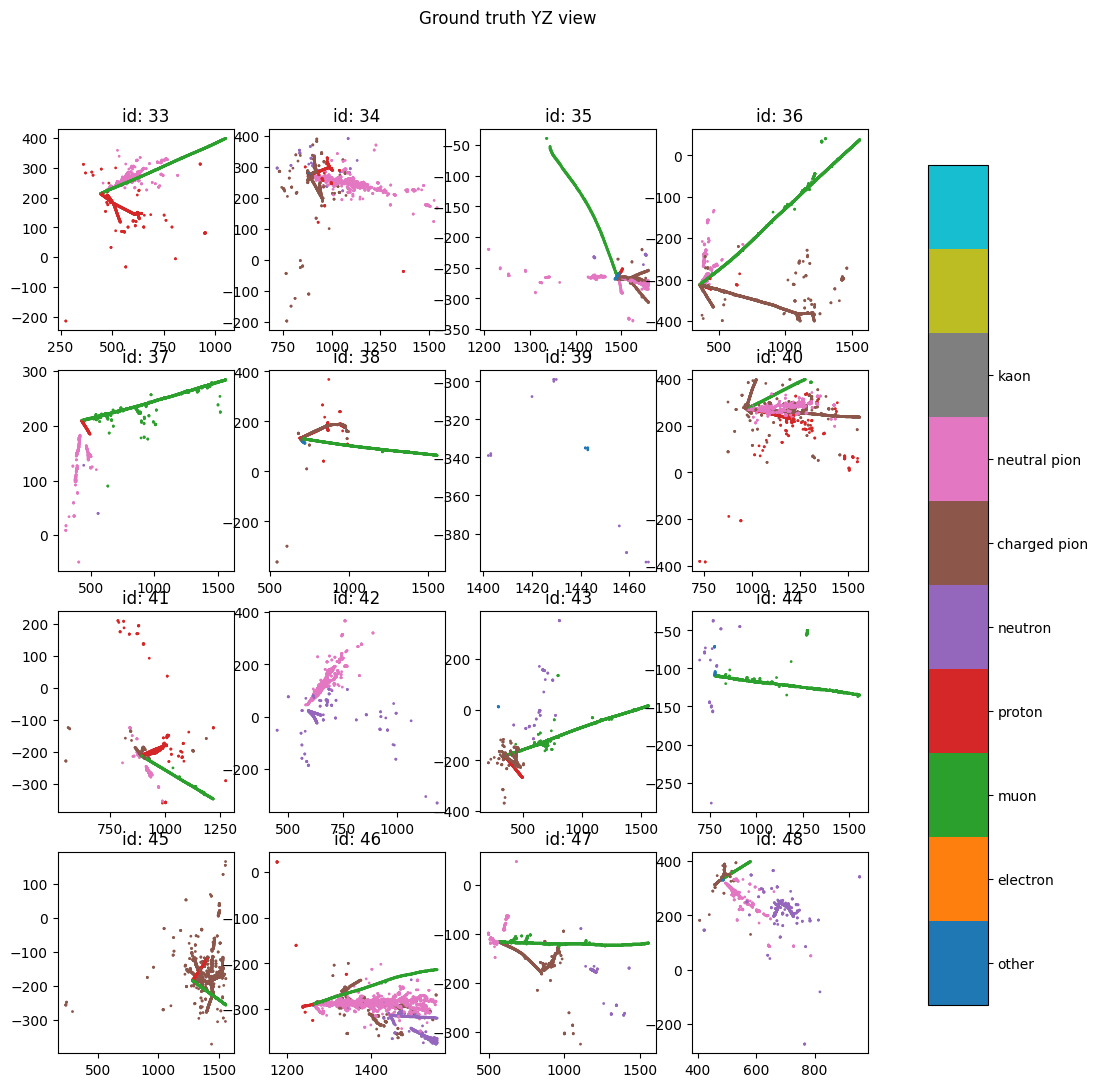

In [39]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_targets1[total_batch_idx1 == i+1+skip]
    im = ax.scatter(c[:,2], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t, cmap="tab10")
    ids = int(total_ids[i+1+skip].item())
    # ax.set_title("unique: %s" % str(t[:,0].unique().tolist()))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth YZ view")
plt.show()

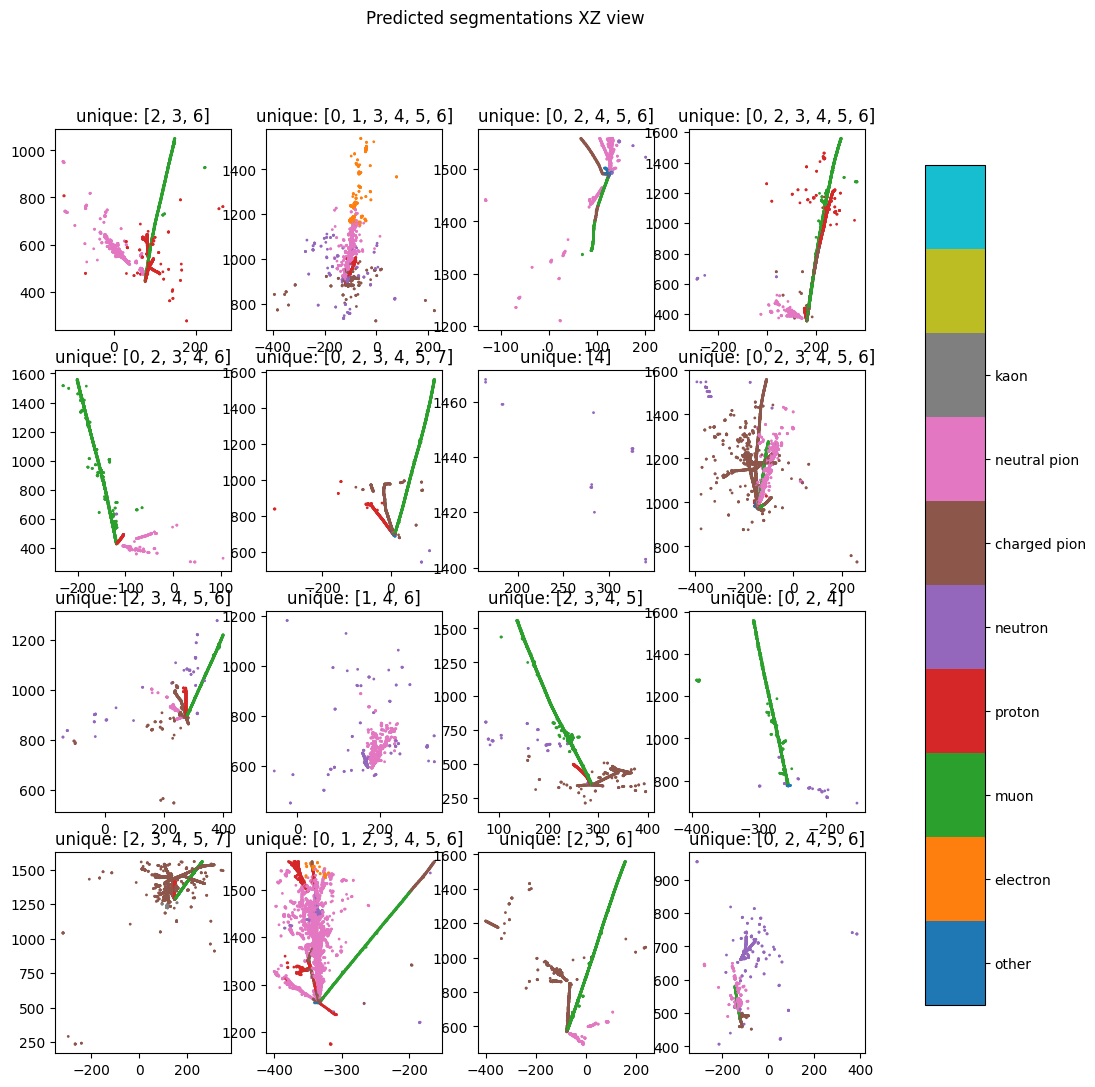

In [40]:
skip = 16*30
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_predictions1[total_batch_idx1 == i+1+skip]
    im = ax.scatter(c[:,0], c[:,2], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations XZ view")
plt.show()

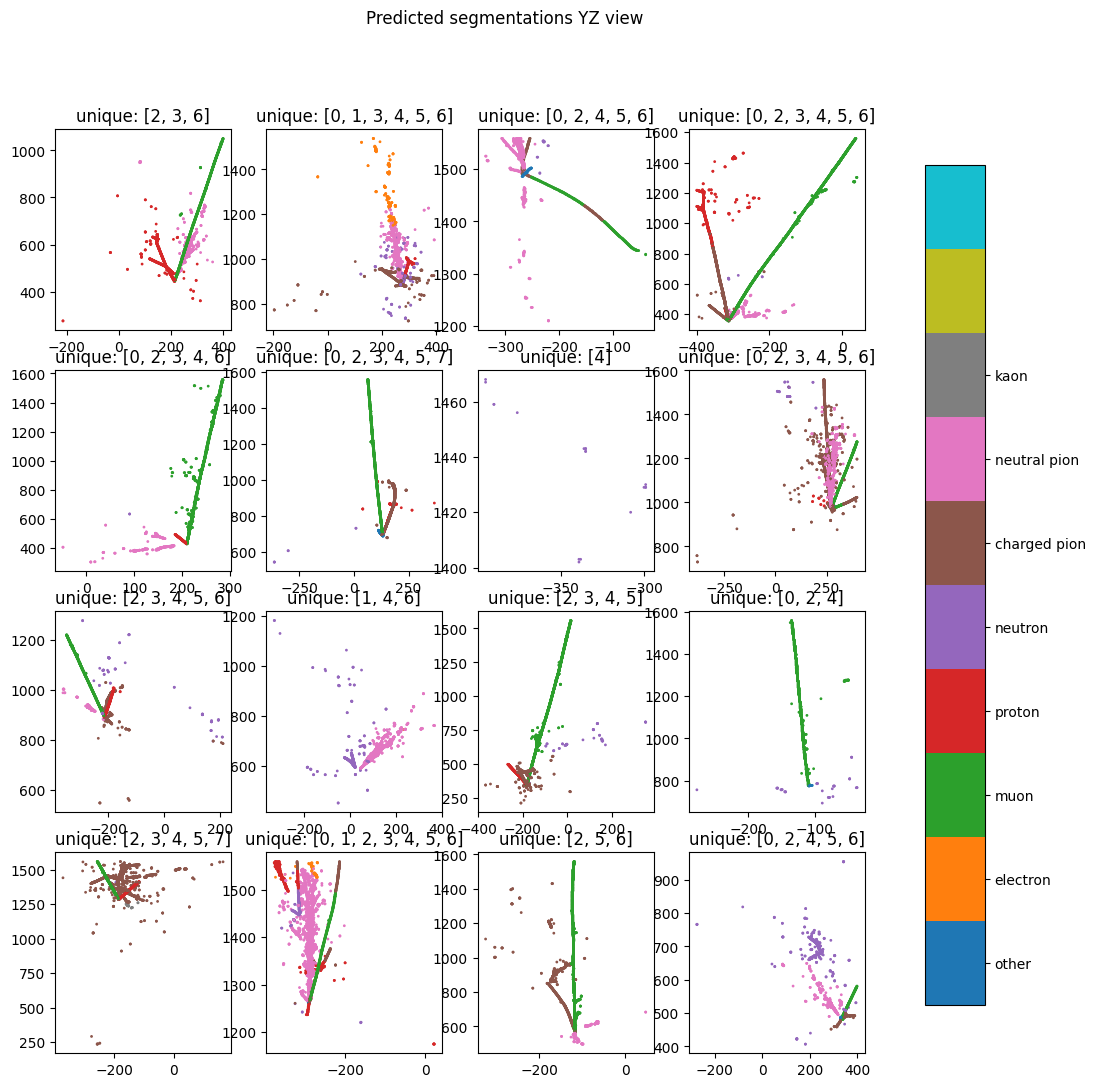

In [41]:
skip = 16*30
fig, axs = plt.subplots(4, 4, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1+skip]
    t = total_predictions1[total_batch_idx1 == i+1+skip]
    im = ax.scatter(c[:,1], c[:,2], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations YZ view")
plt.show()

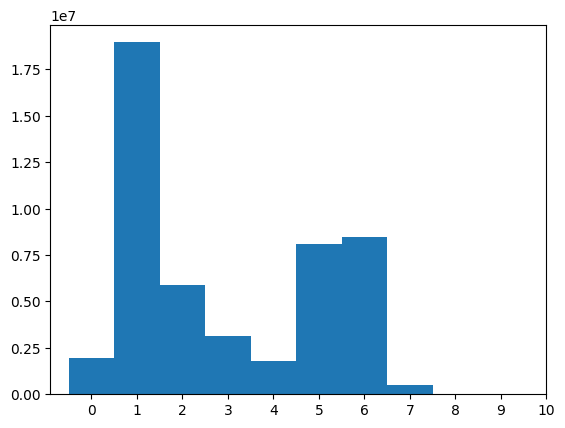

In [42]:
data = range(6)
data = np.array(total_targets)

d = np.diff(np.unique(data)).min()
left_of_first_bin = data.min() - float(d)/2
right_of_last_bin = data.max() + float(d)/2
hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
plt.xticks(range(11))
plt.show()

In [43]:
total_targets.shape

torch.Size([48784594])

# Distribution of values

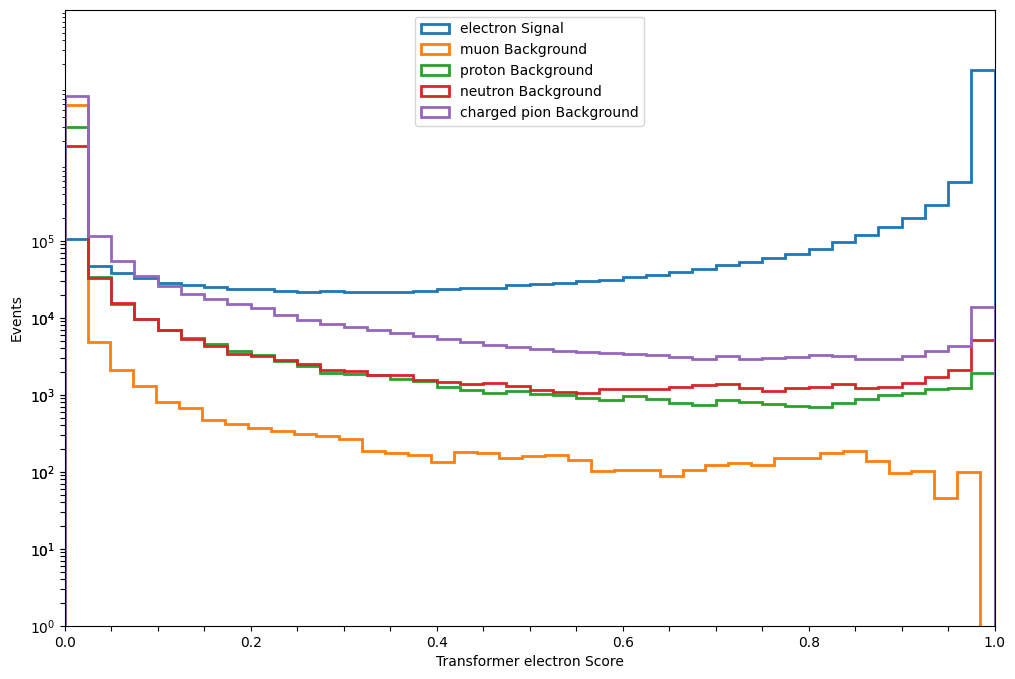

In [44]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

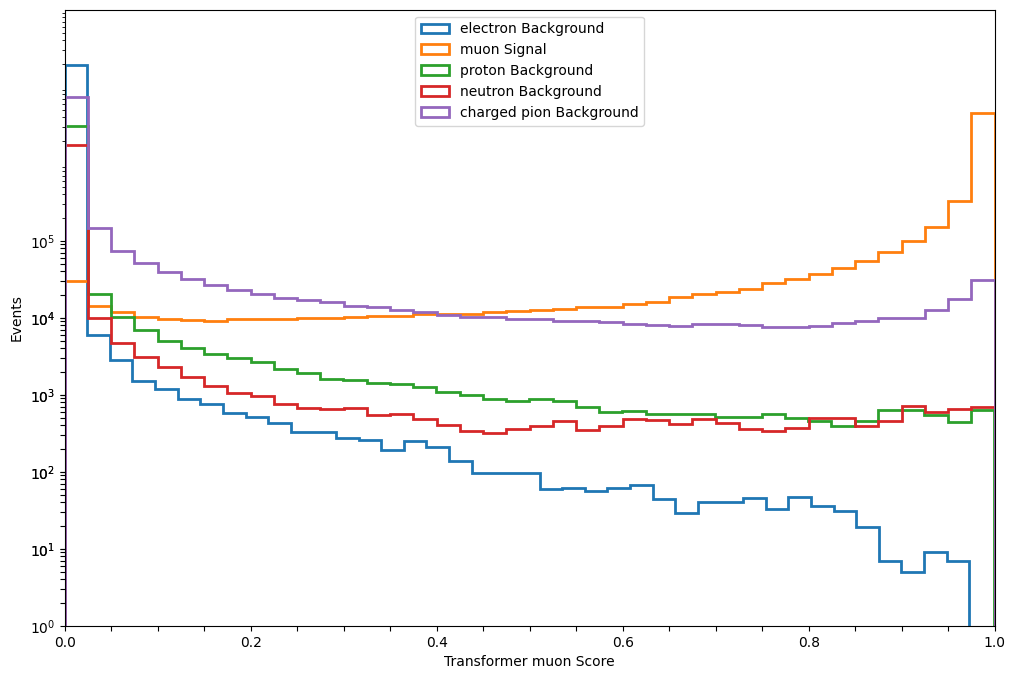

In [45]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 2
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

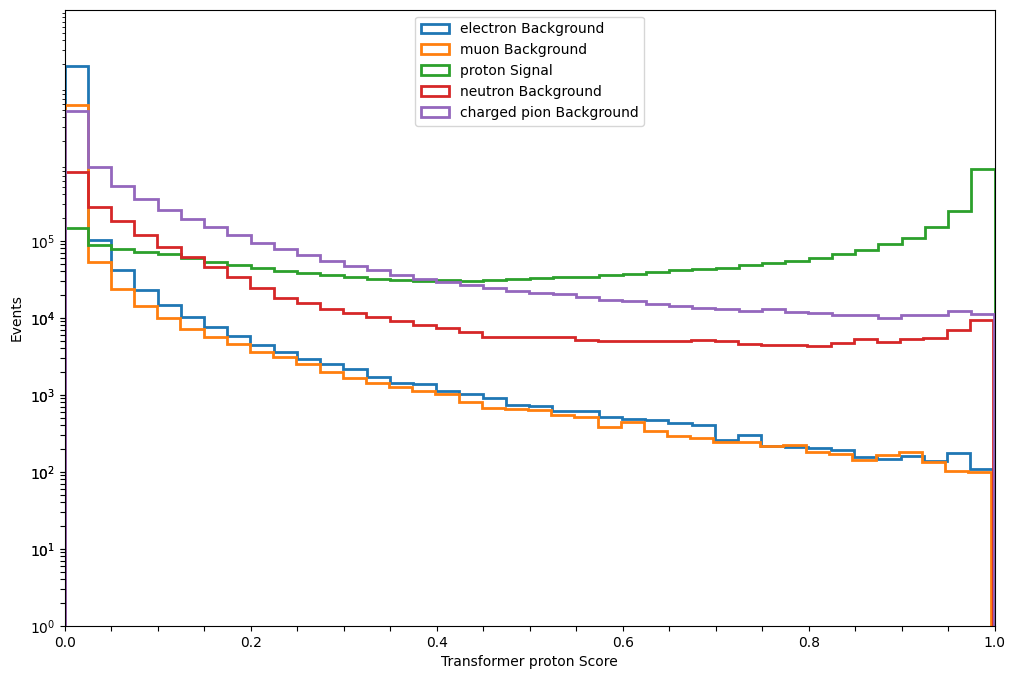

In [46]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 3
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

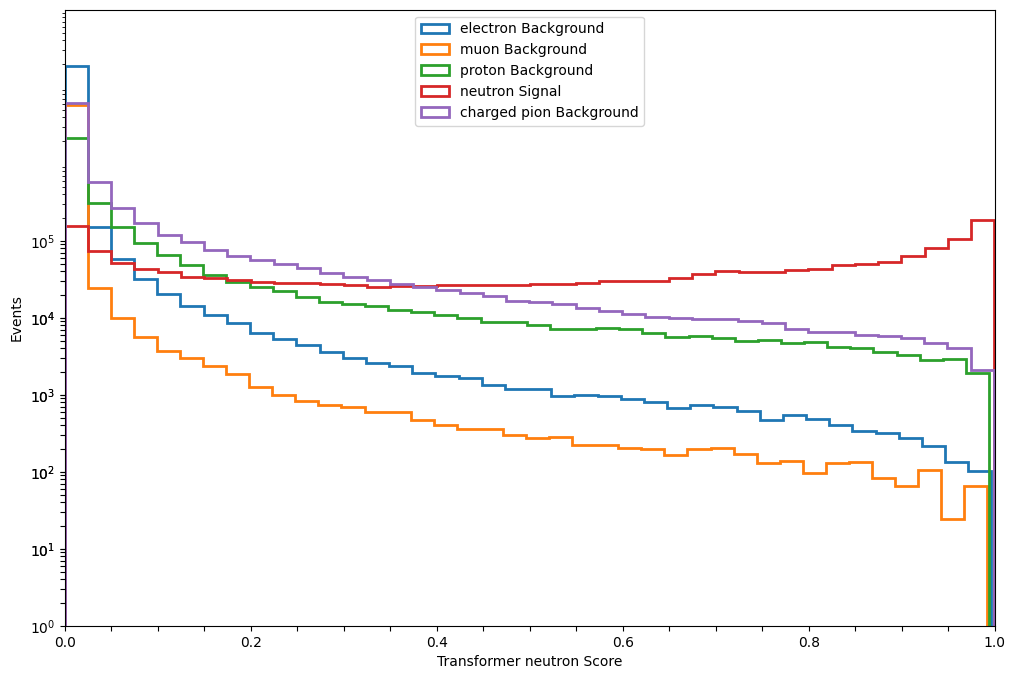

In [47]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 4
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

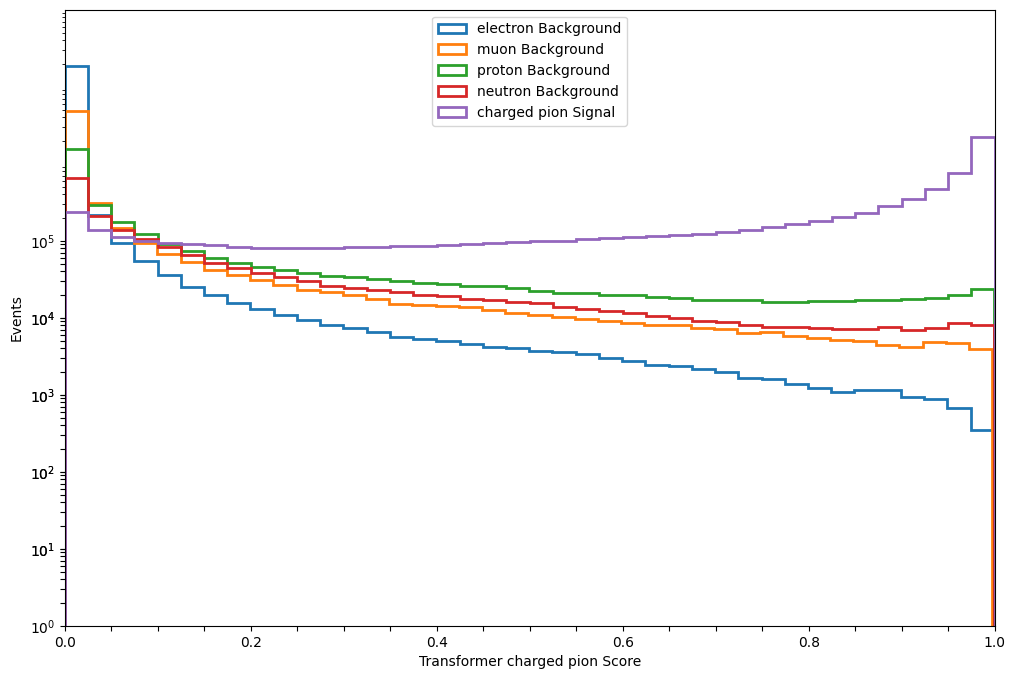

In [48]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 5
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

# Per class distribution

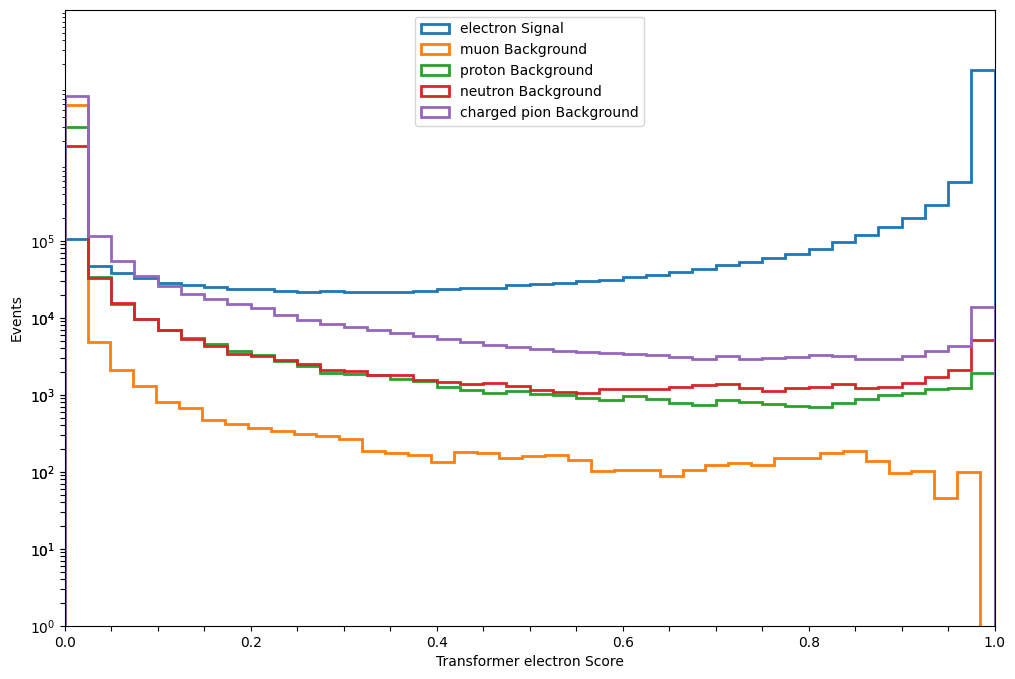

In [49]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[:, target_class].numpy()

for bin_class in range(1,6):
    label = "Signal" if bin_class == target_class else "Background"
        
    plt.hist(binary_scores[total_targets == bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]} {label}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)

plt.ylabel("Events")
plt.xlabel(f"Transformer {CLASS_NAMES[target_class]} Score")
plt.legend(loc="upper center")

In [50]:
total_targets.shape

torch.Size([48784594])

In [51]:
tp.shape

torch.Size([48784594, 8])

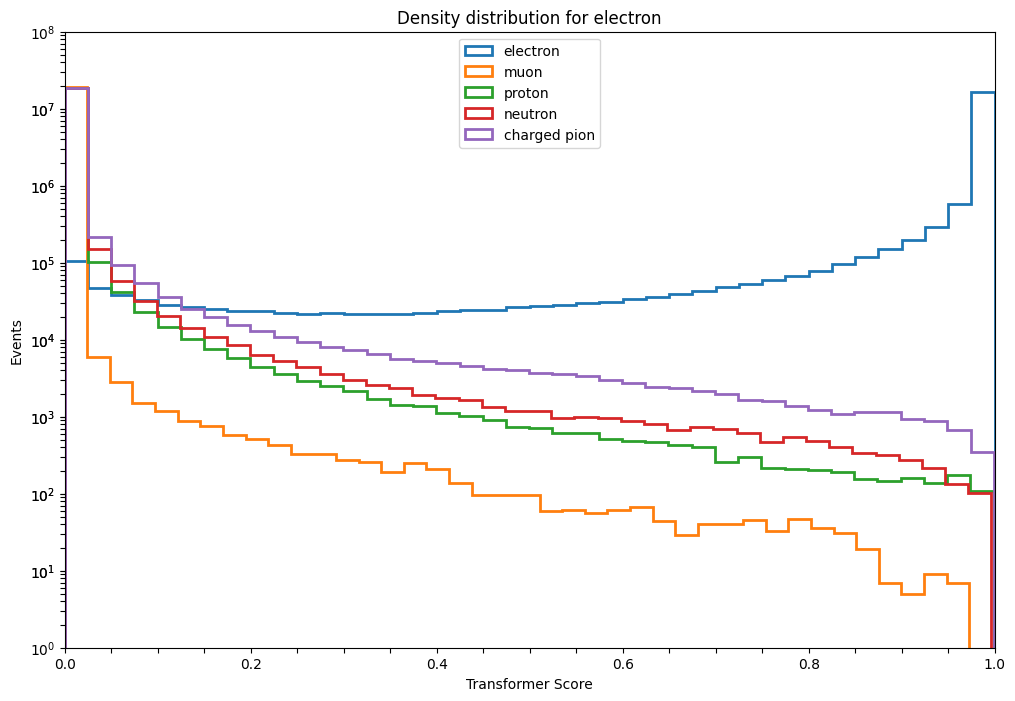

In [52]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 1
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

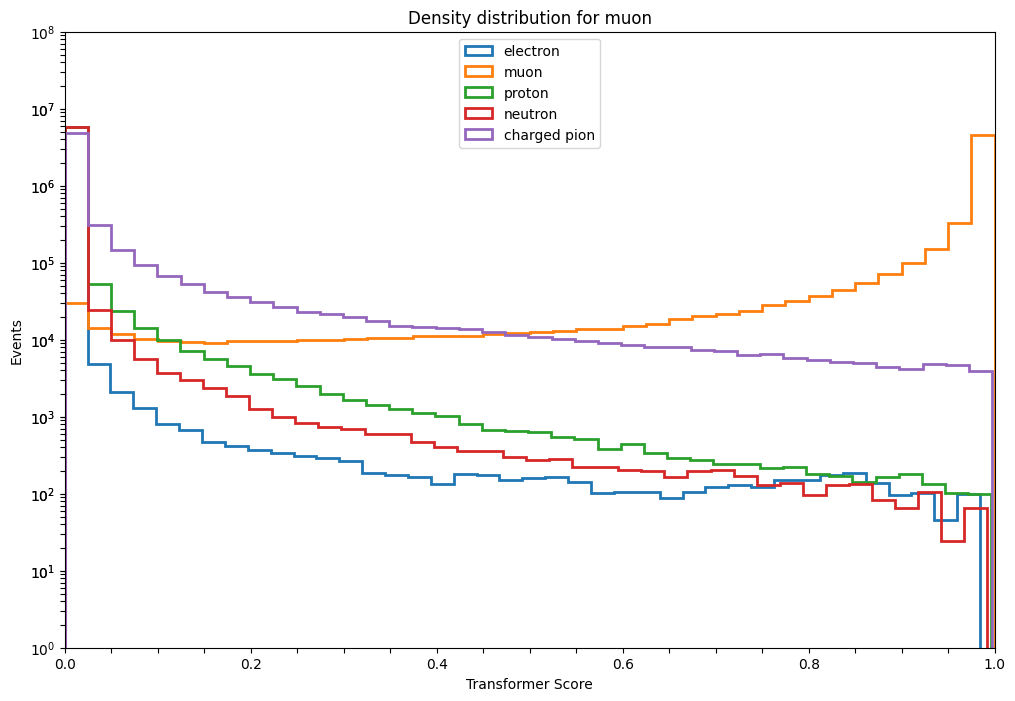

In [53]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 2
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

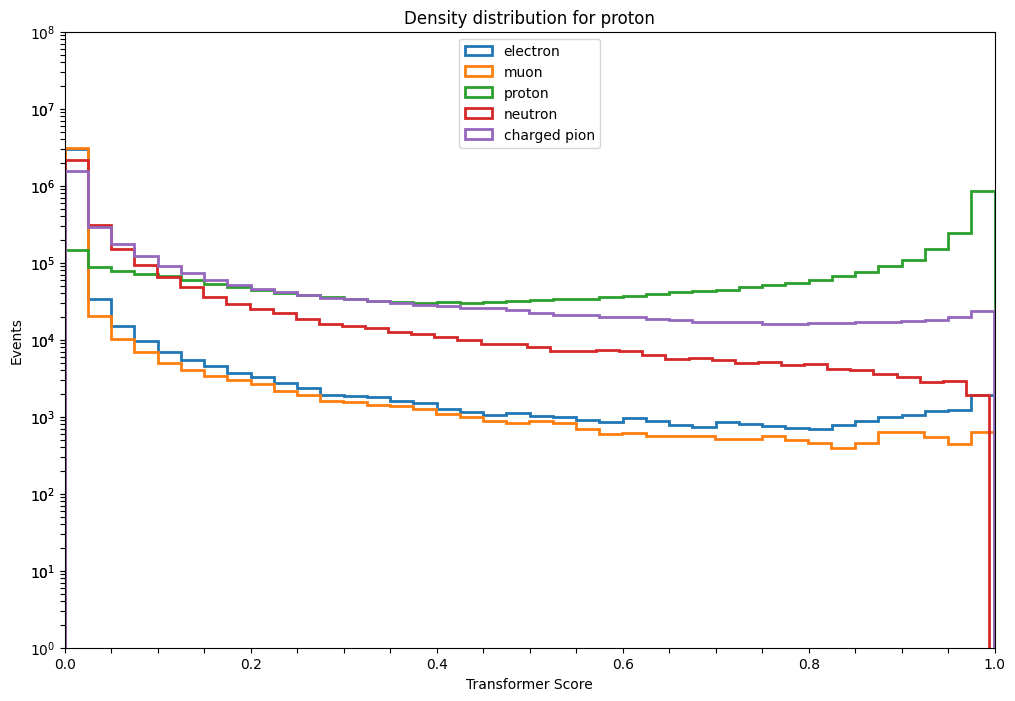

In [54]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 3
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

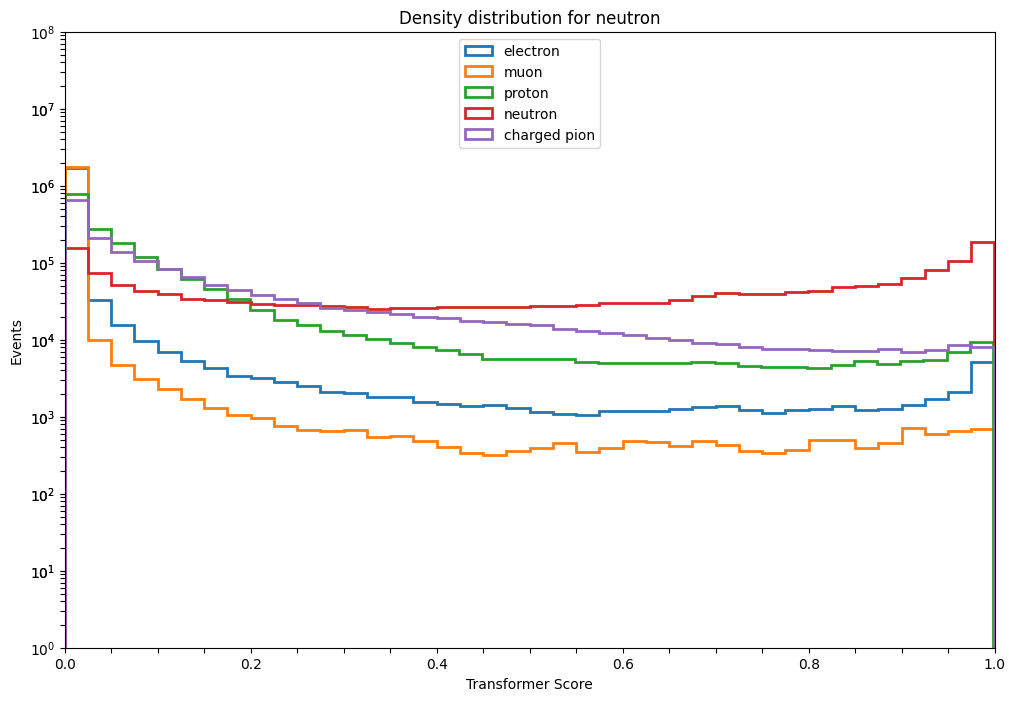

In [55]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 4
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

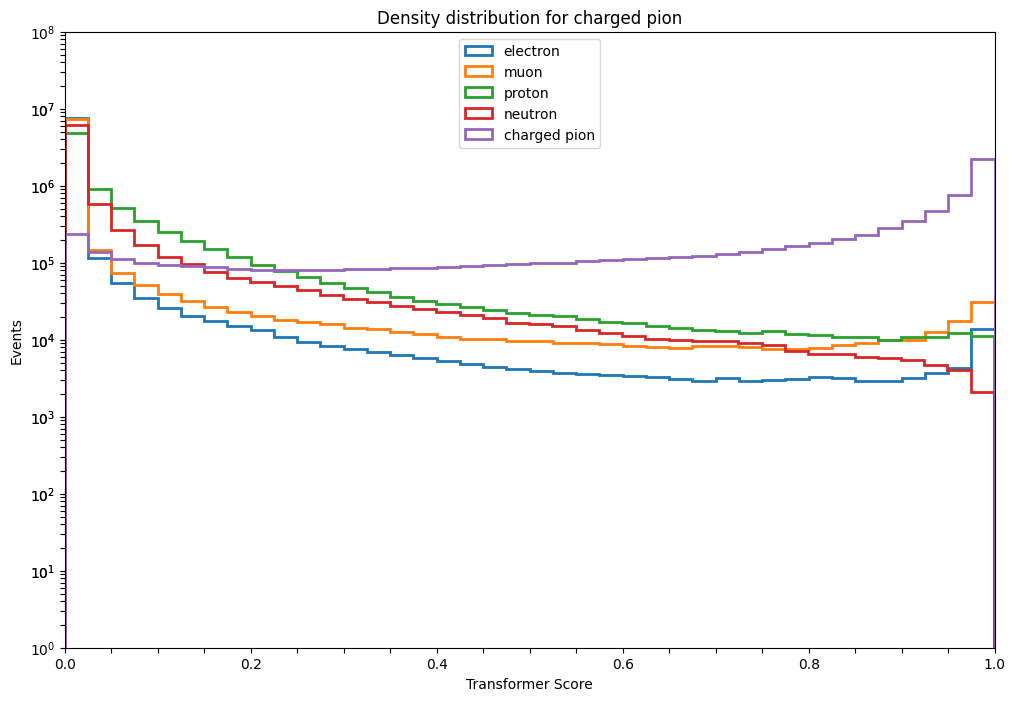

In [56]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

fig, ax = plt.subplots(figsize=(12, 8))

target_class = 5
LINEWIDTH = 2.0
BINS = 5 * 8

binary_scores = tp[total_targets == target_class].numpy()

for bin_class in range(1,6):        
    plt.hist(binary_scores[:, bin_class], histtype='step', bins=BINS, linewidth=LINEWIDTH, label=f"{CLASS_NAMES[bin_class]}");

plt.yscale("log")
plt.yticks(np.concatenate((np.linspace(10**0, 10**1, num=10), np.linspace(10**1, 10**2, num=10), np.linspace(10**2, 10**3, num=10), np.linspace(10**3, 10**4, num=10), np.linspace(10**4, 10**5, num=10), np.linspace(10**5, 10**6, num=10), np.linspace(10**6, 10**7, num=10), np.linspace(10**7, 10**8, num=10))))
plt.xticks(np.linspace(0, 1, 21), labels=["0.0", "", "", "", "0.2", "", "", "", "0.4", "", "", "", "0.6", "", "", "", "0.8", "", "", "", "1.0"])
plt.xlim(0, 1)
plt.ylim(10**0, 10**8)
plt.title(f"Density distribution for {CLASS_NAMES[target_class]}")
plt.ylabel("Events")
plt.xlabel(f"Transformer Score")
plt.legend(loc="upper center")

In [57]:
total_object_targets1

tensor([4, 4, 4,  ..., 3, 4, 4])

In [58]:
total_object_predictions1

tensor([ 9,  9,  9,  ..., 12, 12, 12])

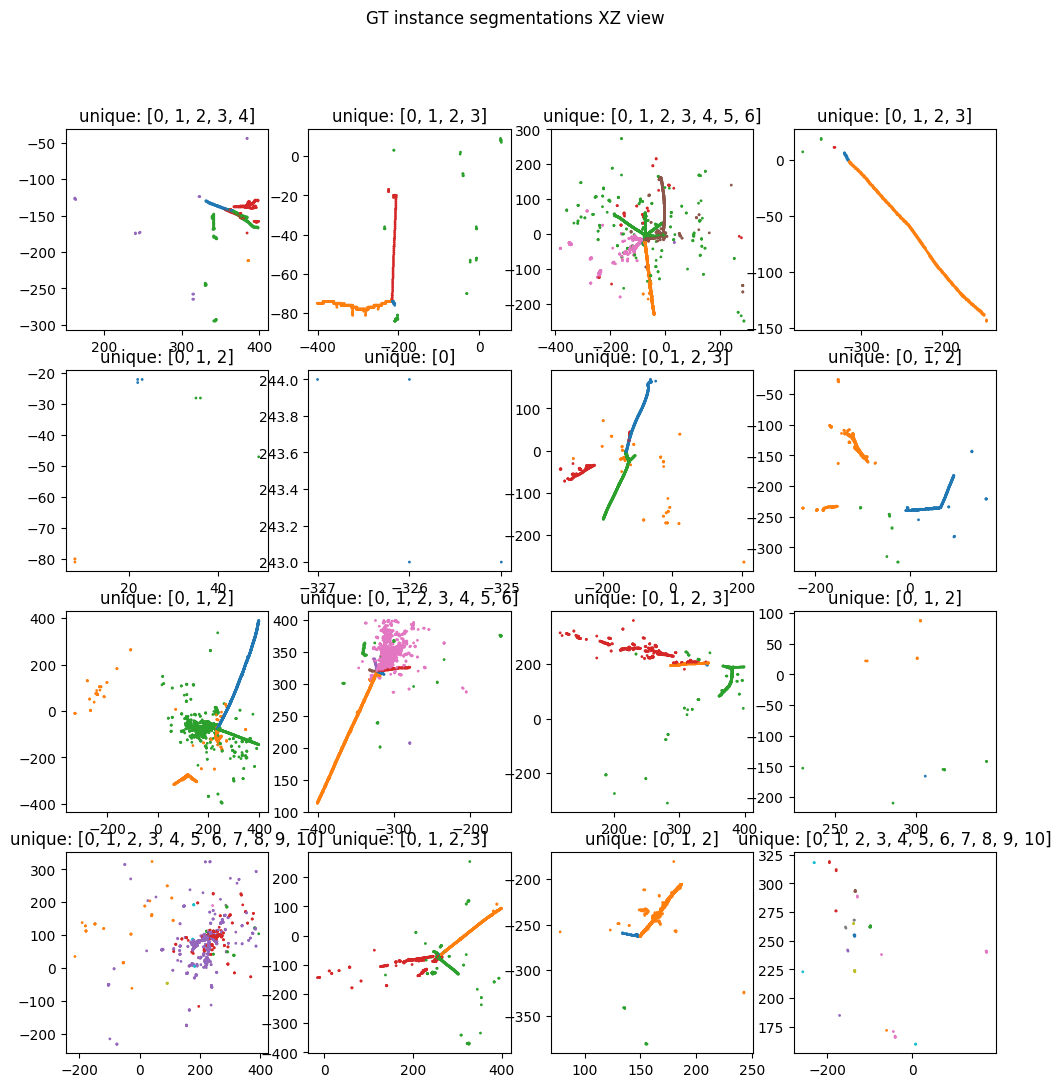

In [59]:
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1]
    t = total_object_targets1[total_batch_idx1 == i+1]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
plt.suptitle("GT instance segmentations XZ view")
plt.show()

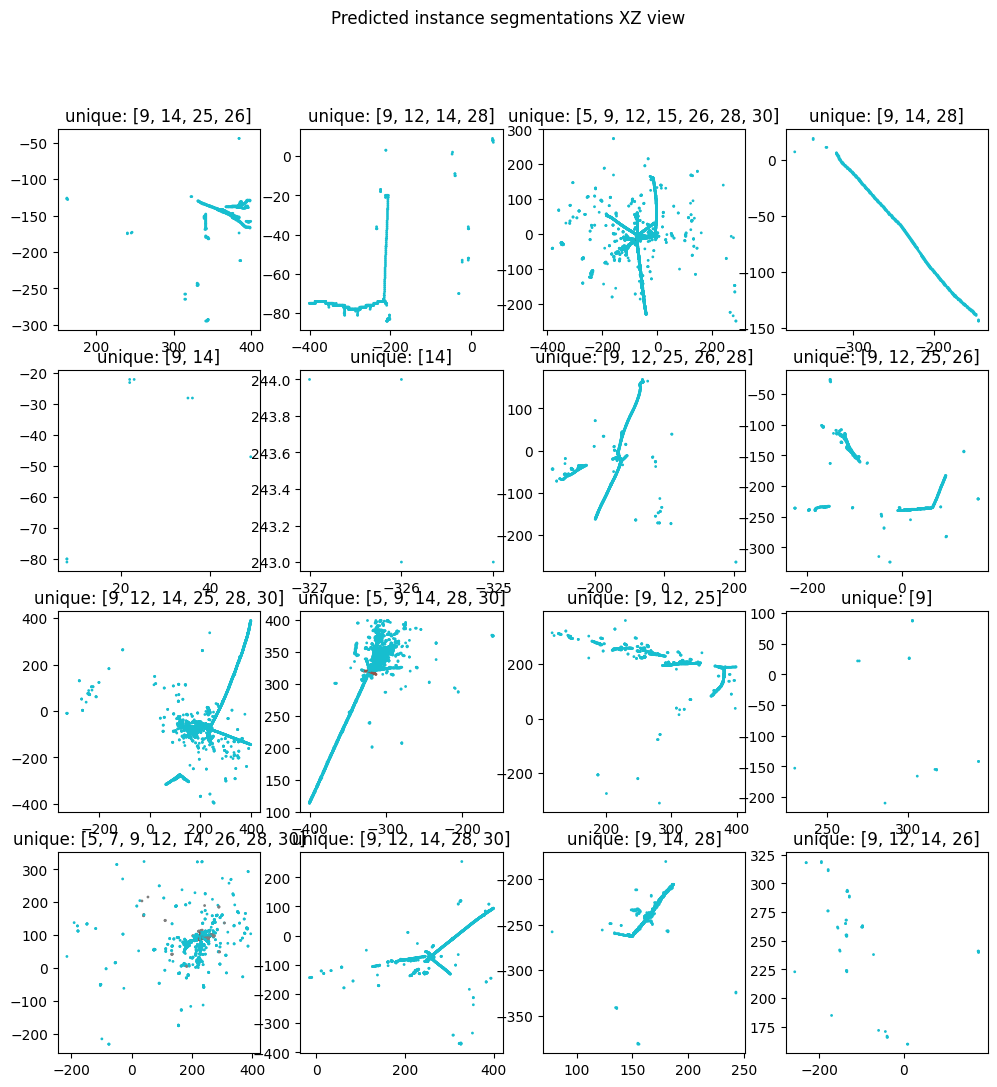

In [60]:
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+1]
    t = total_object_predictions1[total_batch_idx1 == i+1]
    im = ax.scatter(c[:,0], c[:,1], s=1, vmin=-0.5, vmax=9.5, c=t[:], cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
plt.suptitle("Predicted instance segmentations XZ view")
plt.show()

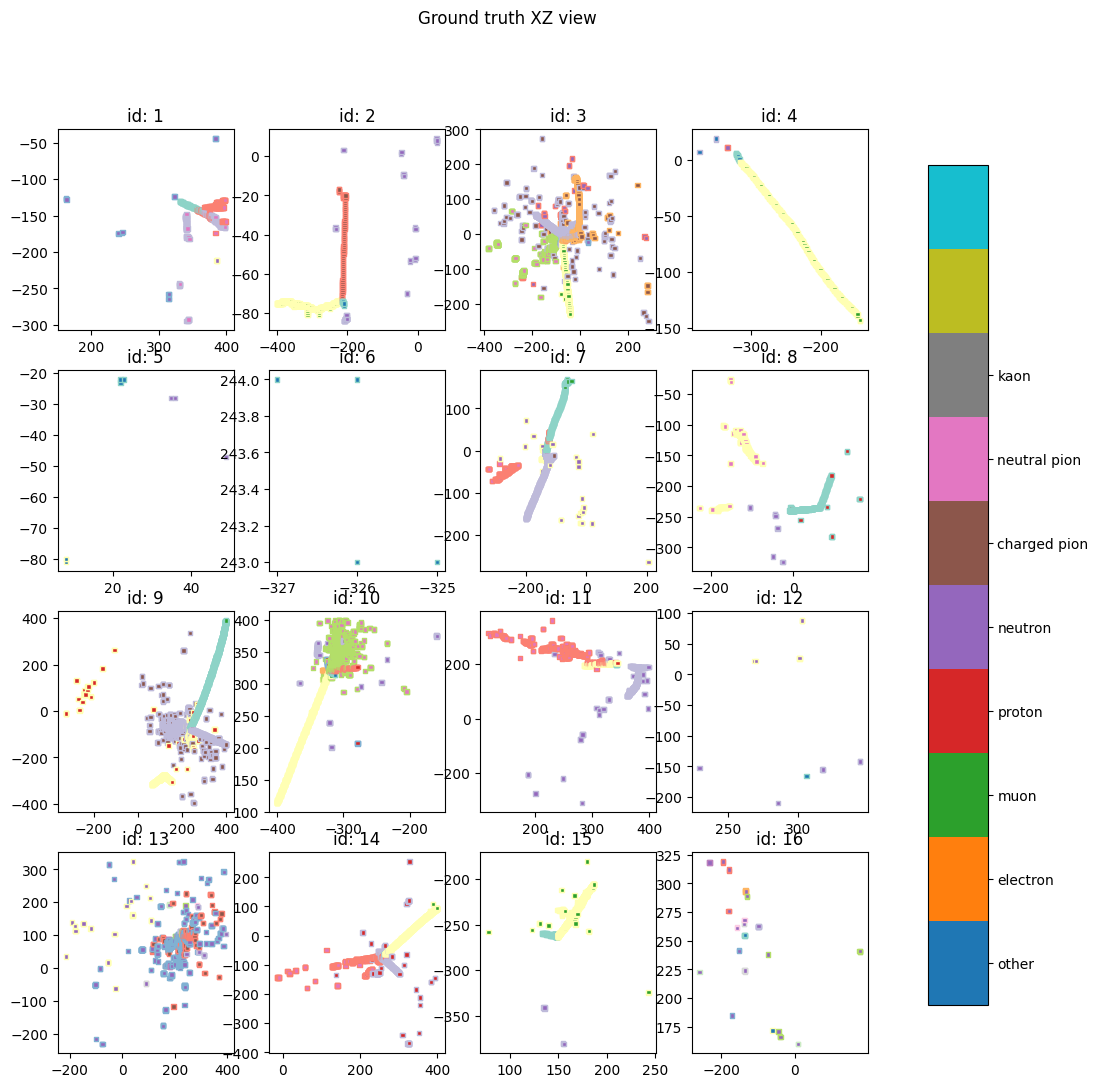

In [61]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+skip]
    t = total_targets1[total_batch_idx1 == i+skip]
    to = total_object_targets1[total_batch_idx1 == i+skip]
    toc = plt.cm.Set3(to)
    ids = int(total_ids[i+skip].item())
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    # ax.set_title("id: %d, unique: %s" % (ids, str(t[:,0].unique().tolist())))
    ax.set_title("id: %d" % (ids))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Ground truth XZ view")
plt.show()

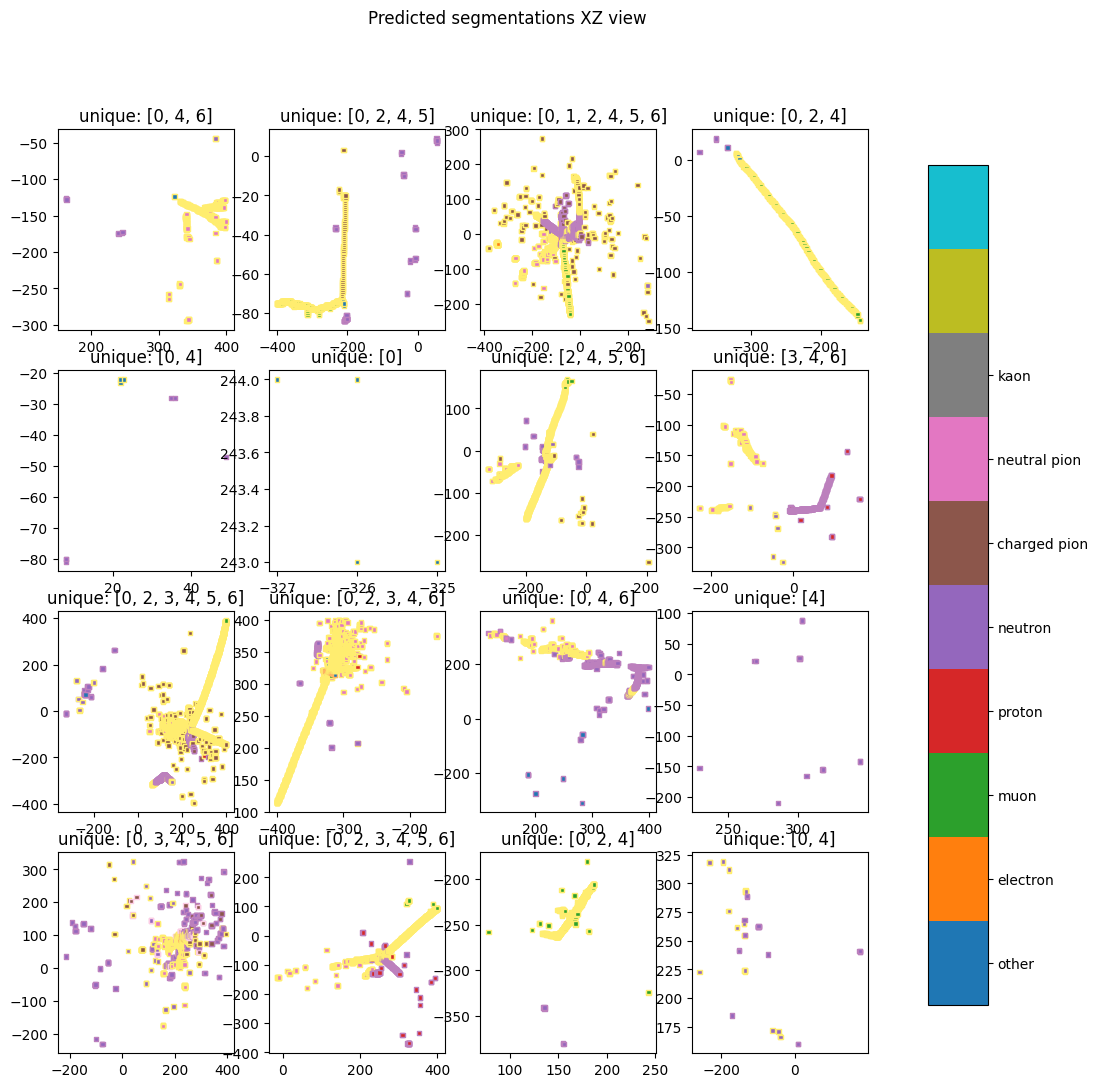

In [62]:
skip = 16*0+1
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(4*3, 4*3))
for i, ax in enumerate(axs.ravel()):
    c = total_coords1[total_batch_idx1 == i+skip]
    t = total_predictions1[total_batch_idx1 == i+skip]
    to = total_object_predictions1[total_batch_idx1 == i+skip]
    toc = plt.cm.Set3(to)
    im = ax.scatter(c[:,0], c[:,1], 
                    s=10, linewidth=-1, marker='s',
                    vmin=-0.5, vmax=9.5, 
                    c=t, edgecolors=toc, 
                    cmap="tab10")
    ax.set_title("unique: %s" % str(t[:].unique().tolist()))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks(list(CLASS_NAMES.keys()))
cbar.set_ticklabels(list(CLASS_NAMES.values()))
plt.suptitle("Predicted segmentations XZ view")
plt.show()

In [63]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [0]*8
n_efficiencies = [0]*8
sum_purities = [0]*8
n_purities = [0]*8

n_corr = 0
n_tot = 0
for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1 = network.forward(
        features1, coordinates1, batches1
    )

    num_objects = 32
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < num_objects))
    #mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = object_predictions1[mask1] #torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = targets1[mask1]
    object_targets = object_targets1[mask1] #torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    batches = batches1[mask1] #torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=num_objects)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(object_targets, num_classes=num_objects), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    batch_target = scatter(targets, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="mean", dim=0)
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, num_objects, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds]/n_true_per_prong[indices, row_inds]
    purs = cost_matrix[indices, row_inds, col_inds]/n_predictions_per_prong[indices, col_inds]
    n_corr += cost_matrix[indices, row_inds, col_inds].sum()
    n_tot += n_predictions_per_prong[indices, col_inds].sum()
    
    for i in range(8):
        ieffs = effs[batch_target == i]
        n_efficiencies[i] += torch.isfinite(ieffs).sum()
        sum_efficiencies[i] += ieffs[torch.isfinite(ieffs)].sum()
        ipurs = purs[batch_target == i]
        n_purities[i] += torch.isfinite(ipurs).sum()
        sum_purities[i] += ipurs[torch.isfinite(ipurs)].sum()


100%|████████████████████████████████████████████████████████████████| 183/183 [01:01<00:00,  2.99it/s]


In [64]:
1

1

In [65]:
print("Prong accuracy: %.03f" % (n_corr/n_tot))

Prong accuracy: 0.888


In [66]:
sum_efficiencies = torch.tensor(sum_efficiencies)
n_efficiencies = torch.tensor(n_efficiencies)
sum_purities = torch.tensor(sum_purities)
n_purities = torch.tensor(n_purities)

In [67]:
for i in range(8):
    print(CLASS_NAMES[i])
    print("Efficiency: ", (sum_efficiencies[i]/n_efficiencies[i]).item())
    print("Purity: ", (sum_purities[i]/n_purities[i]).item())

other
Efficiency:  0.6022738218307495
Purity:  0.4083353579044342
electron
Efficiency:  0.96205735206604
Purity:  0.9558044075965881
muon
Efficiency:  0.9518093466758728
Purity:  0.9604133367538452
proton
Efficiency:  0.7384382486343384
Purity:  0.8394335508346558
neutron
Efficiency:  0.3405623733997345
Purity:  0.6687381863594055
charged pion
Efficiency:  0.6814499497413635
Purity:  0.7864105701446533
neutral pion
Efficiency:  0.77092444896698
Purity:  0.84339439868927
kaon
Efficiency:  0.6972422003746033
Purity:  0.7705852389335632


In [68]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [[] for _ in range(8)]
n_efficiencies = [[] for _ in range(8)]
sum_purities = [[] for _ in range(8)]
n_purities = [[] for _ in range(8)]
n_trues = [[] for _ in range(8)]
n_predicteds = [[] for _ in range(8)]

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1 = network.forward(
        features1, coordinates1, batches1
    )

    num_objects = 32
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < num_objects))
    #mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = object_predictions1[mask1] #torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = targets1[mask1] #object_targets1[mask1] #torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    object_targets = object_targets1[mask1]
    batches = batches1[mask1] #torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=num_objects)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(object_targets, num_classes=num_objects), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    #print(targets.shape, num_objects*batch_size)
    #batch_target = scatter(targets, (batches*num_objects)+targets, dim_size=num_objects*batch_size, reduce="mean", dim=0)
    batch_target = torch.zeros((num_objects*batch_size,), dtype=targets.dtype, device=targets.device)
    batch_target[(batches*num_objects)+object_targets] = targets
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, num_objects, -1)) # (batch_size, 10, 10)
    cpu_cm = cost_matrix.detach().cpu().numpy()
    row_inds, col_inds, indices = [], [], []
    for i, cm in enumerate(cpu_cm):
        row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
        row_ind = torch.from_numpy(row_ind)
        col_ind = torch.from_numpy(col_ind)
        index = i*torch.ones_like(row_ind)
        
        row_inds.append(row_ind)
        col_inds.append(col_ind)
        indices.append(index)

    row_inds = torch.cat(row_inds, dim=0).to(cost_matrix.device)
    col_inds = torch.cat(col_inds, dim=0).to(cost_matrix.device)
    indices = torch.cat(indices, dim=0).to(cost_matrix.device)
    
    effs = cost_matrix[indices, row_inds, col_inds]/n_true_per_prong[indices, row_inds]
    purs = cost_matrix[indices, row_inds, col_inds]/n_predictions_per_prong[indices, col_inds]
    n_corr += cost_matrix[indices, row_inds, col_inds].sum()
    n_tot += n_predictions_per_prong[indices, col_inds].sum()
    
    """
    assigned_costs, assigned_cost_idx = cost_matrix.max(dim=-2)
    
    merged_costs = scatter(assigned_costs, assigned_cost_idx, dim_size=32, reduce="sum", dim=-1)
    n_predictions_per_prong = scatter(n_predictions_per_prong, assigned_cost_idx, dim_size=32, reduce="sum", dim=-1)
    
    effs = merged_costs.to(float)/n_true_per_prong.to(float)
    purs = merged_costs.to(float)/n_predictions_per_prong.to(float)
    
    if (effs > 1).any():
        print(assigned_costs[0])
        print(assigned_cost_idx[0])
        print(merged_costs[0])
        print(n_true_per_prong[0])
        print(effs[0])
        print(purs[0])
        asdf
    """
    
    for i in range(8):
        ntrues = n_true_per_prong.reshape((-1))[batch_target == i]
        npredicteds = n_predictions_per_prong.reshape((-1))[batch_target == i]
        
        ieffs = effs.reshape((-1))[batch_target == i]
        ipurs = purs.reshape((-1))[batch_target == i]
        mask = torch.isfinite(ieffs) & torch.isfinite(ipurs)
        sum_efficiencies[i].append(ieffs[mask].detach().cpu())
        sum_purities[i].append(ipurs[mask].detach().cpu())
        n_trues[i].append(ntrues[mask].detach().cpu())
        n_predicteds[i].append(npredicteds[mask].detach().cpu())

100%|████████████████████████████████████████████████████████████████| 183/183 [01:01<00:00,  2.95it/s]


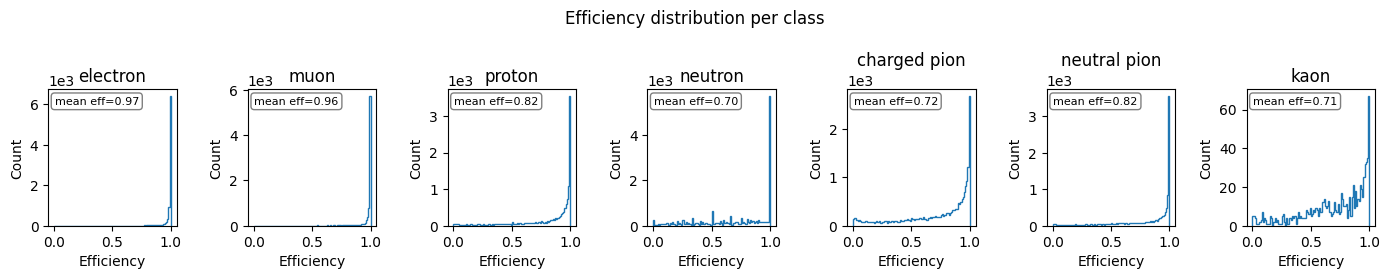

In [69]:
figwidth = 14
fig, axs = plt.subplots(1,7,figsize=(figwidth, figwidth/5))
for i in range(1,8):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    textstr = f"mean eff=%.02f"%mean_eff
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Efficiency distribution per class")
plt.tight_layout()
plt.savefig("effdist.pdf", format="pdf", bbox_inches="tight")

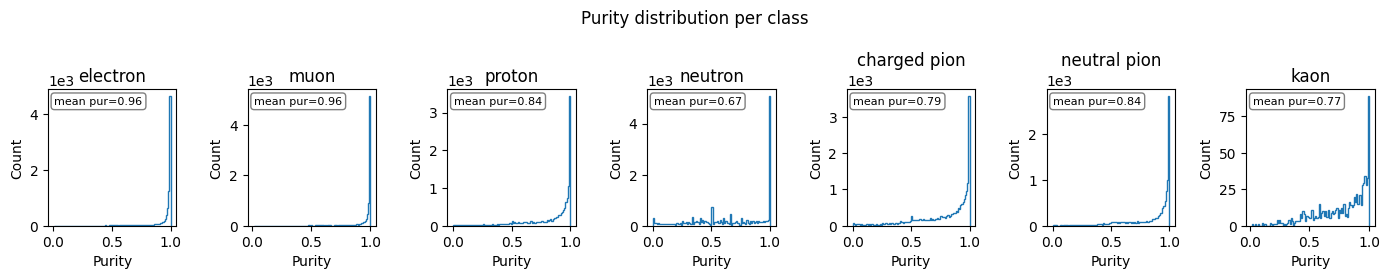

In [70]:
figwidth = 14
fig, axs = plt.subplots(1,7,figsize=(figwidth, figwidth/5))
for i in range(1,8):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    textstr = f"mean pur=%.02f"%mean_pur
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Purity distribution per class")
plt.tight_layout()
plt.savefig("purdist.pdf", format="pdf", bbox_inches="tight")

In [71]:
from torch_scatter import scatter
from scipy.optimize import linear_sum_assignment

sum_efficiencies = [[] for _ in range(8)]
n_efficiencies = [[] for _ in range(8)]
sum_purities = [[] for _ in range(8)]
n_purities = [[] for _ in range(8)]
n_trues = [[] for _ in range(8)]
n_predicteds = [[] for _ in range(8)]

for batch_idx, batch in enumerate(tqdm(test_dataloader)):
    if CUDA:
        batch = [b.cuda(CUDA_DEVICE) for b in batch]
    
    (
        ids,
        batches1, 
        features1, 
        coordinates1, 
        targets1,
        object_targets1,
    ) = batch
    
    # coordinates1 = torch.nn.functional.pad(coordinates1, (0,1), "constant", 0)
    # coordinates1[:,-1] = coordinates1[:,1]
    # coordinates2 = torch.nn.functional.pad(coordinates2, (0,1), "constant", 0)
    # coordinates2[:,-1] = coordinates2[:,1]
    
    predictions1, object_predictions1 = network.forward(
        features1, coordinates1, batches1
    )

    num_objects = 32
    
    mask1 = ((targets1 != -1) & (object_targets1 != -1) & (object_targets1 < num_objects))
    #mask2 = ((targets2 != -1) & (object_targets2 != -1) & (object_targets2 < 10))
    
    logits = object_predictions1[mask1] #torch.cat((object_predictions1[mask1], object_predictions2[mask2]), dim=0)
    targets = targets1[mask1] #object_targets1[mask1] #torch.cat((object_targets1[mask1], object_targets2[mask2]), dim=0)
    object_targets = object_targets1[mask1]
    batches = batches1[mask1] #torch.cat((batches1[mask1], batches2[mask2]), dim=0)
    
    _, object_preds = torch.max(logits, dim=-1)
    object_preds = F.one_hot(object_preds, num_classes=num_objects)
    
    batch_size = batches.max()
    batch_size = batch_size + 1
    pre_reshape_cost_matrix = scatter(object_preds, (batches*num_objects)+object_targets, dim_size=num_objects*batch_size, reduce="sum", dim=0)
    n_predictions_per_prong = scatter(object_preds, batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the column
    n_true_per_prong = scatter(F.one_hot(object_targets, num_classes=num_objects), batches, dim_size=batch_size, reduce="sum", dim=0) # -> (batch_size, 10) this 10 belongs to the rows
    #print(targets.shape, num_objects*batch_size)
    #batch_target = scatter(targets, (batches*num_objects)+targets, dim_size=num_objects*batch_size, reduce="mean", dim=0)
    batch_target = torch.zeros((num_objects*batch_size,), dtype=targets.dtype, device=targets.device)
    batch_target[(batches*num_objects)+object_targets] = targets
    
    # cost_matrix = cost_matrix.reshape((10, batch_size, -1)).transpose(0,1)
    cost_matrix = pre_reshape_cost_matrix.reshape((batch_size, num_objects, -1)) # (batch_size, 10, 10)
    assigned_costs, assigned_cost_idx = cost_matrix.max(dim=-2)
    
    merged_costs = scatter(assigned_costs, assigned_cost_idx, dim_size=32, reduce="sum", dim=-1)
    n_predictions_per_prong = scatter(n_predictions_per_prong, assigned_cost_idx, dim_size=32, reduce="sum", dim=-1)
    
    effs = merged_costs.to(float)/n_true_per_prong.to(float)
    purs = merged_costs.to(float)/n_predictions_per_prong.to(float)
    
    if (effs > 1).any():
        print(assigned_costs[0])
        print(assigned_cost_idx[0])
        print(merged_costs[0])
        print(n_true_per_prong[0])
        print(effs[0])
        print(purs[0])
        asdf
    
    for i in range(8):
        ntrues = n_true_per_prong.reshape((-1))[batch_target == i]
        npredicteds = n_predictions_per_prong.reshape((-1))[batch_target == i]
        
        ieffs = effs.reshape((-1))[batch_target == i]
        ipurs = purs.reshape((-1))[batch_target == i]
        mask = torch.isfinite(ieffs) & torch.isfinite(ipurs)
        sum_efficiencies[i].append(ieffs[mask].detach().cpu())
        sum_purities[i].append(ipurs[mask].detach().cpu())
        n_trues[i].append(ntrues[mask].detach().cpu())
        n_predicteds[i].append(npredicteds[mask].detach().cpu())

100%|████████████████████████████████████████████████████████████████| 183/183 [01:01<00:00,  2.97it/s]


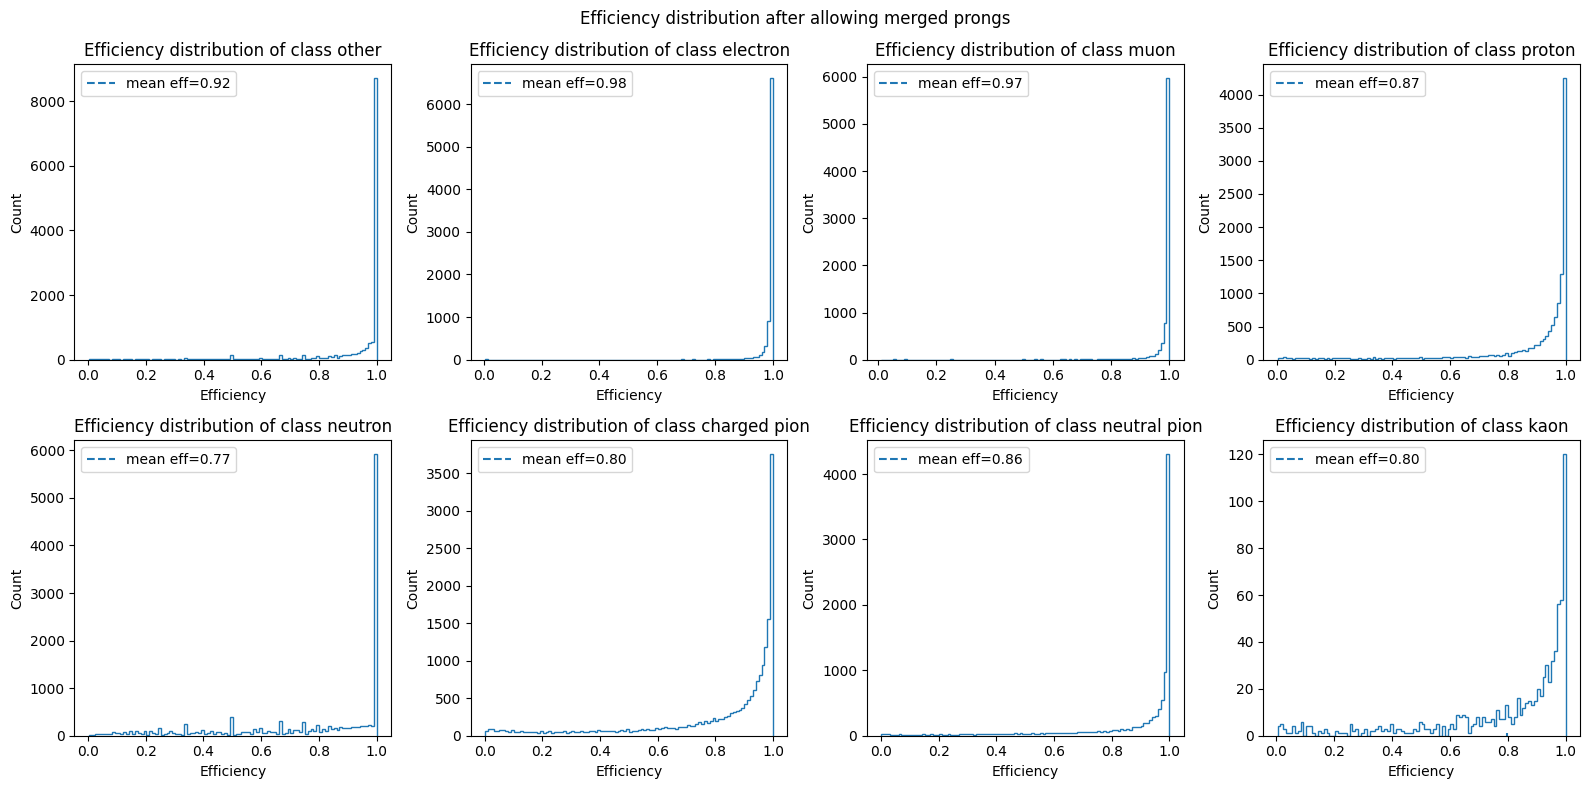

In [72]:
fig, axs = plt.subplots(2,4,figsize=(4*4, 2*4))
for i in range(8):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"Efficiency distribution of class {name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean eff=%.02f"%mean_eff)
    ax.legend()
plt.suptitle("Efficiency distribution after allowing merged prongs")
plt.tight_layout()
plt.show()

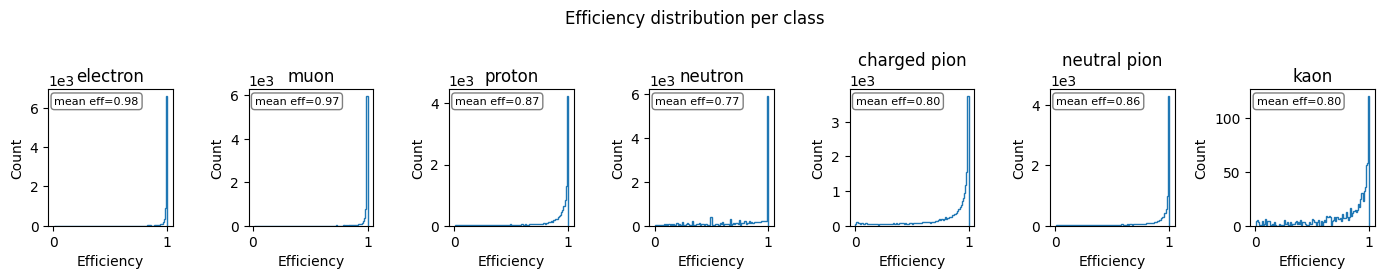

In [73]:
figwidth = 14
fig, axs = plt.subplots(1,7,figsize=(figwidth, figwidth/5))
for i in range(1,8):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    efficiencies = torch.cat(sum_efficiencies[i])
    mean_eff = efficiencies.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Efficiency")
    ax.set_ylabel("Count")
    ax.hist(efficiencies.numpy(), bins=100, histtype='step')
    textstr = f"mean eff=%.02f"%mean_eff
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Efficiency distribution per class")
plt.tight_layout()
plt.savefig("effdist.pdf", format="pdf", bbox_inches="tight")

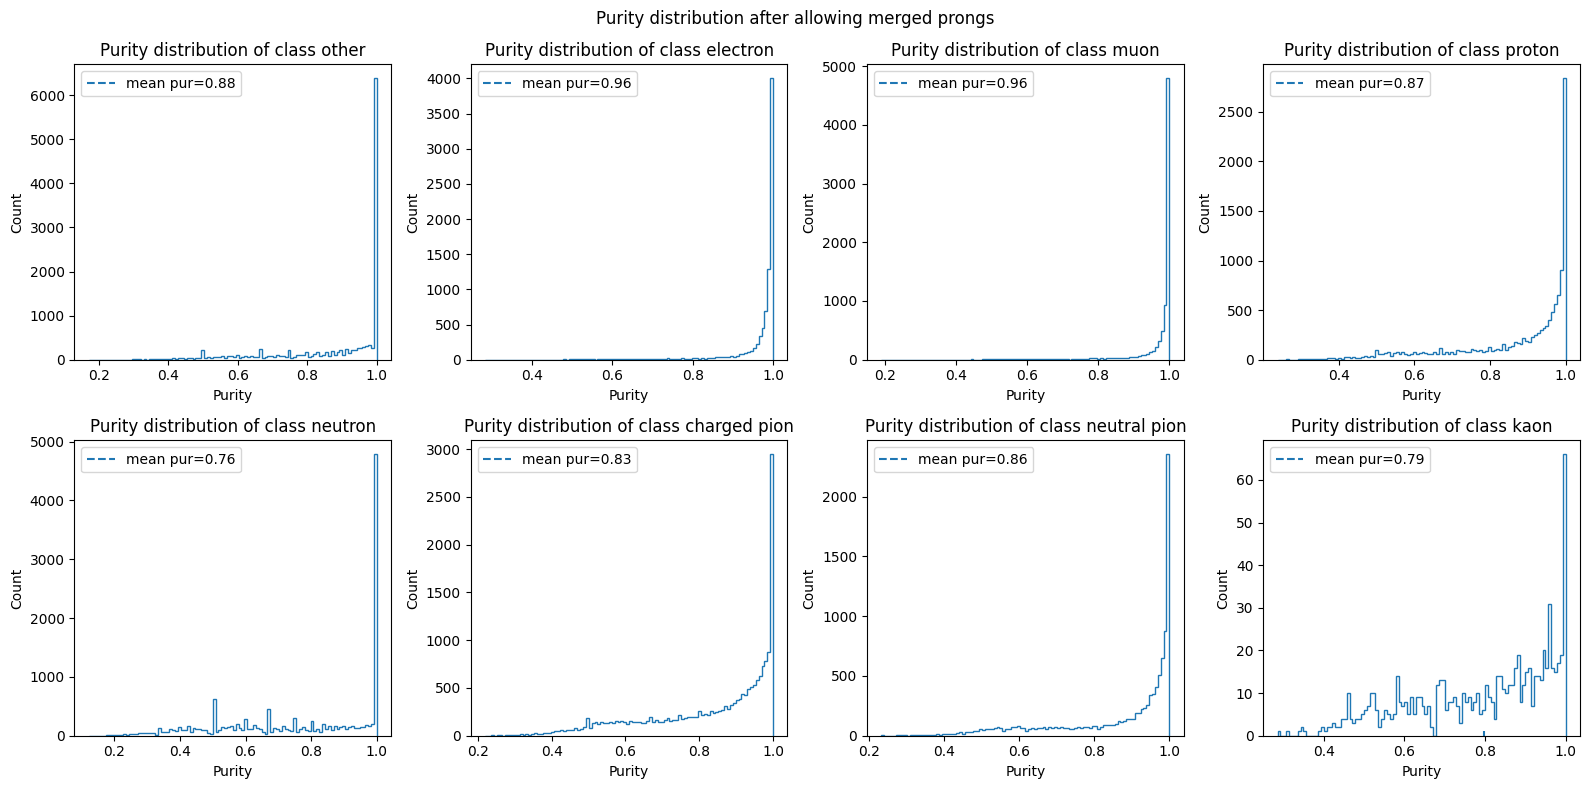

In [74]:
fig, axs = plt.subplots(2,4,figsize=(4*4, 2*4))
for i in range(8):
    ax = axs.ravel()[i]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"Purity distribution of class {name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    ax.vlines(mean_eff, 0, 1, linestyles='dashed', label=f"mean pur=%.02f"%mean_pur)
    ax.legend()
plt.suptitle("Purity distribution after allowing merged prongs")
plt.tight_layout()
plt.show()

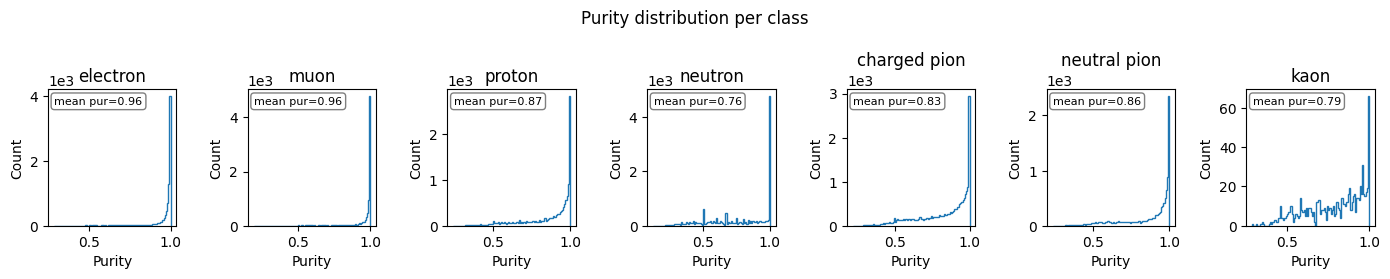

In [75]:
figwidth = 14
fig, axs = plt.subplots(1,7,figsize=(figwidth, figwidth/5))
for i in range(1,8):
    ax = axs.ravel()[i-1]
    name = CLASS_NAMES[i]
    purities = torch.cat(sum_purities[i])
    mean_pur = purities.mean()
    ax.set_title(f"{name}")
    ax.set_xlabel("Purity")
    ax.set_ylabel("Count")
    ax.hist(purities.numpy(), bins=100, histtype='step')
    textstr = f"mean pur=%.02f"%mean_pur
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    ax.ticklabel_format(axis='y', scilimits=[-3, 3])
plt.suptitle("Purity distribution per class")
plt.tight_layout()
plt.savefig("purdist.pdf", format="pdf", bbox_inches="tight")